# Лекция 9. Использование внешних библиотек, динамическое связывание.  Использование Docker.

1. Создание и использование библиотек, их классификация.
2. Использование библиотек на примере ncurses.
3. Установка и настройка Docker

## 1. Создание и использование библиотек, их классификация.

В прошлой лекции мы уже начали использовать внешние библиотеки совместно с ассемблером.
Существует два основных способа использования созданных библиотечных файлов: построение **статических и динамических библиотек**.

**Динамические библиотеки** хранятся отдельно от исполняемых файлов, как правило, в системных директориях. Они могут использоваться сразу многими исполняемыми файлами, поэтому их еще называют **разделяемые библиотеки**. Еще одно преимущество этого способа - сравнительно малый объем исполняемого файла. Однако в таком способе есть и недостатки. Если у пользователя нет в системе соответствующей динамической библиотеки, исполняемый файл работать не будет.

Процесс сборки динамической библиотеки включает в себя следующие этапы:
- Компиляция библиотечных файлов без линковки (для gcc  это использование ключа компиляции -c). В результате выполнения этих команд в текущей директории будет созданы объектные файлы с расширением .o
- Создание динамической библиотеки из объектных файлов. В gcc для этих целей необходимо использовать ключ компиляции -shared, указывая имя библиотеки с расширением .so, а также имена объектных файлов, из которых она будет построена. Например,:

    > gcc -shared -o libmy.so func.o method.o
    
    После этого в текущей директории будет создана динамическая библиотека с именем libmy.so.

- Чтобы получить доступ к динамической библиотеке, исполняемый файл должен знать, где она находится. Для пользовательских библиотек в системе GNU Linux чаще всего используется системная директория /usr/lib. Именно туда и нужно переместить созданный файл libmy.so.

    > sudo mv ./libmy.so /usr/lib

    Обратите внимание, поскольку директория /usr/lib системная, требуются права администратора (команда sudo).

    Вместо физического перемещения файла libmy.so можно создать на него символическую ссылку:

    > sudo ln -s ./libmy.so /usr/lib/
    

Для сборки статической библиотеки вместо компилятора gcc в ключом -shared необходимо просто заархивировать созданные объектные файлы в архив с расширением .a:

> ar r libmy.a func.o method.o

После этого выполнить общую компиляцию:

>gcc -o solver main.c  -L -lmy -lm

Здесь ключ -L указывает, что библиотеку libmy.a следует искать в текущей директории. После компиляции файл статической библиотеки libmy.a можно удалить, так как она полностью добавляется в исполняемый файл, что делает его более автономным. Однако это приводит к увеличению его объема, не позволяет другим программам использовать эту библиотеку.


При вызове функций C/C++ из ассемблера используются соглашения **ABI (Application Binary Interface или бинарный интерфейс приложения)**. В Linux применяемый интерфейс ABI еще называется **"System V ABI"**. System V Application Binary Interface — это набор спецификаций, которые подробно описывают соглашения о вызовах, форматы объектных файлов, форматы исполняемых файлов, семантику динамического связывания и многое другое. Сегодня это стандартный ABI, используемый основными операционными системами Unix, такими как Linux, системы BSD и многими другими.

**Для 32-битной платформы** параметры функций передаются в стек в обратном порядке, так что первый параметр является последним значением, помещенным в стек. Еще одним важным вопросом является понятие **выравнивание стека** - значение, хранящееся в регистре стека должно быть кратно некоторому числу. Для старых систем стек все время выровнен по 4 байтам. В некоторых новых системах стек дополнительно выровнен по 16 байтам непосредственно перед вызовом инструкции call.

Функции сохраняют регистры **ebx , esi , edi , ebp и esp**; в то время как **eax , ecx , edx** являются изменяемымми регистрами. 

Возвращаемое значение сохраняется в регистре **eax** или, если это 64-битное значение, то старшие 32 бита помещаются в **edx** . 

**Для 64-битной платформы** параметры функций передаются в регистрах **rdi , rsi , rdx , rcx , r8 , r9**, а дальнейшие значения передаются в стек в обратном порядке. Параметры, переданные в стек, могут быть изменены вызываемой функцией. Стек должен быть выровнен по 16 байтам (значение указателя стека **rsp** должно быть кратно 16) непосредственно перед вызовом инструкции call. 

Функции сохраняют регистры **rbx , rsp , rbp , r12 , r13 , r14 и r15**; в то время как **rax , rdi , rsi , rdx , rcx , r8 , r9 , r10 , r11** являются изменяемыми регистрами. Возвращаемое значение сохраняется в регистре rax или, если это 128-битное значение, то старшие 64 бита помещаются в **rdx**.

Если функция в качестве параметров принимает числа с плавающей точкой, то они передаются через регистры **xmm0, xmm1, xmm2, xmm3, xmm4, xmm5, xmm6, xmm7**. Если функция принимает значения как с плавающей точкой, так и целые числа, то целые числа передаются обычным способом (с использованием **rdi, rsi, rdx, rcx, r8 и r9**), а числа с плавающей точкой передаются с использованием регистров **XMM**.

Кроме того, для функций (таких как printf или scanf), которые принимают переменное количество аргументов, количество используемых регистров XMM должно быть помещено в rax. 

Если возвращаемое значение является значением с плавающей запятой, оно возвращается в **xmm0**. Если возвращаются два значения, то через регистры **xmm1:xmm0**.

Рассмотрим несколько фактических примеров.

**Пример 1.** Использование встроенной функции **printf** из языка C в ассемблере - предусмотрим передачу нашей программе двух параметров командной строки, программа должна находить их сумму и выводить ее в качестве результата. При этом мы будем использовать штатную функцию C **printf** по типу **printf("%d+%d=%d", a, b, c)**.

Например, на языке C эта программа выглядела бы так:


In [ ]:
/*example1.c*/
#include <stdio.h>
#include <stdlib.h>
int main(int argc, /*Параметр хранит количество параметров командной строки */ 
         char **argv/*Хранит указатель на начало строки параметров*/){
    int a, b;
    a = atoi(argv[1]); /*С помощью atoi преобразуем строку в число */
    b = atoi(argv[2]);
    printf("%d+%d=%d\n",a,b,a+b);
    return 0;
}

Ниже приведен скриншот работы данной программы

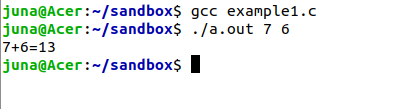

Если мы будем вызывать printf из ассемблера, то есть два различных способа: использовать для линковки ld или использовать для линковки gcc. Рассмотрим оба этих способа.

Ниже представлена программа, подготовленная для линковки ld.

In [ ]:
;;example2.asm
    
format elf64

	public _start

	include "func.asm"

	extrn printf

	section '.data' writable

	msg db "%d+%d=%d", 0xa, 0
	
_start:
	mov rcx, [rsp]
	cmp rcx, 3
	jne ext
	mov rsi, [rsp+16]
	call str_number
	mov r8, rax
	mov rsi, [rsp+24]
	call str_number
	mov r9, rax
	mov rsi, r8
	mov rdx, r9
	mov rcx, rsi
	add rcx, rdx
	mov rdi, msg
	call printf
ext:
	call exit

Как видно из программы, в регистр **rdi** мы загружаем адрес строки msg, в регистр **rsi** - прочитанный и преобразованный в число первый параметр командной строки, в регистр **rdx** - прочитанный и преобразованный в число второй параметр командной строки, в региср **rcx** - сумму чисел из параметров командной строки. Саму функцию **printf** мы указали как внешнюю (extrn).

Важным вопросом является правильная линковка объектного файла, позволяющая найти все необходимые разделяемые библиотеки языка C. 

По сути здесь мы должны использовать **динамический компоновщик** - в его задачи входит: определение и загрузка зависимостей; перемещение (relocate) приложения и всех зависимостей; инициализация приложения и зависимостей в правильном порядке.

Каждый исполняемый файл содержит ссылку, по сути говорящую: «Мне нужна библиотека MyLib». Когда программа загружается, система должна либо проверить, не загрузила ли уже какая-либо другая программа код для библиотеки MyLib в память, и таким образом, она сможет поделиться им, отобразив страницы в исполняемом файле для этой физической памяти, либо иным образом загрузить библиотеку в память для исполняемого файла.

Этот процесс называется **динамическим связыванием**, поскольку он выполняет часть процесса связывания «на лету», по мере выполнения программ в системе.

При компиляции программы, использующей динамическую библиотеку, в объектных файлах сохраняются ссылки на библиотечные функции.

Несмотря на то, что динамический компоновщик выполняет большую часть работы для общих библиотек, традиционный компоновщик все еще играет определенную роль в создании исполняемого файла.

Традиционному компоновщику необходимо оставить указатель в исполняемом файле, чтобы динамический компоновщик знал, какая библиотека удовлетворит зависимости во время выполнения.

Для того, чтобы посмотреть зависимости исполняемого файла от динамических библиотек, можно использовать утилиту **readelf** с параметром **--dynamic**. Например, созданная выше программа на языке С имеет следующую структуру:

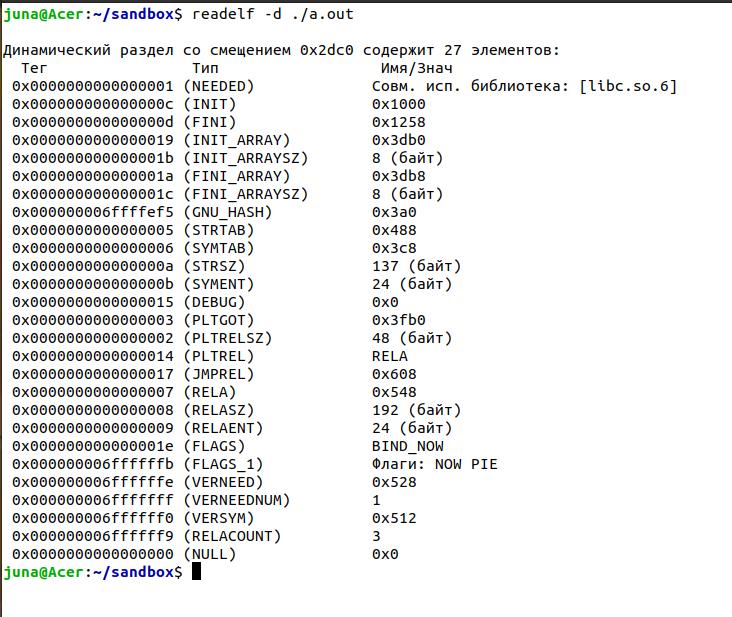

Таким образом, видно, что имеется зависимость от библиотеки libc.so.6

[Наиболее обширная информация предоставляется по ключу -**a**](https://habr.com/ru/articles/480642/).

In [ ]:
juna@Acer:~/sandbox$ readelf -a ./a.out
Заголовок ELF:
  Magic:   7f 45 4c 46 02 01 01 00 00 00 00 00 00 00 00 00 
  Класс:                             ELF64
  Данные:                            дополнение до 2, от младшего к старшему
  Version:                           1 (current)
  OS/ABI:                            UNIX - System V
  Версия ABI:                        0
  Тип:                               DYN (Совм. исп. объектный файл)
  Машина:                            Advanced Micro Devices X86-64
  Версия:                            0x1
  Адрес точки входа:               0x1080
  Начало заголовков программы:          64 (байт в файле)
  Начало заголовков раздела:          14760 (байт в файле)
  Флаги:                             0x0
  Size of this header:               64 (bytes)
  Size of program headers:           56 (bytes)
  Number of program headers:         13
  Size of section headers:           64 (bytes)
  Number of section headers:         31
  Section header string table index: 30

Заголовки разделов:
  [Нм] Имя               Тип              Адрес             Смещение
       Размер            Разм.Ent         Флаги  Ссылк Инфо  Выравн
  [ 0]                   NULL             0000000000000000  00000000
       0000000000000000  0000000000000000           0     0     0
  [ 1] .interp           PROGBITS         0000000000000318  00000318
       000000000000001c  0000000000000000   A       0     0     1
  [ 2] .note.gnu.propert NOTE             0000000000000338  00000338
       0000000000000020  0000000000000000   A       0     0     8
  [ 3] .note.gnu.build-i NOTE             0000000000000358  00000358
       0000000000000024  0000000000000000   A       0     0     4
  [ 4] .note.ABI-tag     NOTE             000000000000037c  0000037c
       0000000000000020  0000000000000000   A       0     0     4
  [ 5] .gnu.hash         GNU_HASH         00000000000003a0  000003a0
       0000000000000024  0000000000000000   A       6     0     8
  [ 6] .dynsym           DYNSYM           00000000000003c8  000003c8
       00000000000000c0  0000000000000018   A       7     1     8
  [ 7] .dynstr           STRTAB           0000000000000488  00000488
       0000000000000089  0000000000000000   A       0     0     1
  [ 8] .gnu.version      VERSYM           0000000000000512  00000512
       0000000000000010  0000000000000002   A       6     0     2
  [ 9] .gnu.version_r    VERNEED          0000000000000528  00000528
       0000000000000020  0000000000000000   A       7     1     8
  [10] .rela.dyn         RELA             0000000000000548  00000548
       00000000000000c0  0000000000000018   A       6     0     8
  [11] .rela.plt         RELA             0000000000000608  00000608
       0000000000000030  0000000000000018  AI       6    24     8
  [12] .init             PROGBITS         0000000000001000  00001000
       000000000000001b  0000000000000000  AX       0     0     4
  [13] .plt              PROGBITS         0000000000001020  00001020
       0000000000000030  0000000000000010  AX       0     0     16
  [14] .plt.got          PROGBITS         0000000000001050  00001050
       0000000000000010  0000000000000010  AX       0     0     16
  [15] .plt.sec          PROGBITS         0000000000001060  00001060
       0000000000000020  0000000000000010  AX       0     0     16
  [16] .text             PROGBITS         0000000000001080  00001080
       00000000000001d5  0000000000000000  AX       0     0     16
  [17] .fini             PROGBITS         0000000000001258  00001258
       000000000000000d  0000000000000000  AX       0     0     4
  [18] .rodata           PROGBITS         0000000000002000  00002000
       000000000000000e  0000000000000000   A       0     0     4
  [19] .eh_frame_hdr     PROGBITS         0000000000002010  00002010
       0000000000000044  0000000000000000   A       0     0     4
  [20] .eh_frame         PROGBITS         0000000000002058  00002058
       0000000000000108  0000000000000000   A       0     0     8
  [21] .init_array       INIT_ARRAY       0000000000003db0  00002db0
       0000000000000008  0000000000000008  WA       0     0     8
  [22] .fini_array       FINI_ARRAY       0000000000003db8  00002db8
       0000000000000008  0000000000000008  WA       0     0     8
  [23] .dynamic          DYNAMIC          0000000000003dc0  00002dc0
       00000000000001f0  0000000000000010  WA       7     0     8
  [24] .got              PROGBITS         0000000000003fb0  00002fb0
       0000000000000050  0000000000000008  WA       0     0     8
  [25] .data             PROGBITS         0000000000004000  00003000
       0000000000000010  0000000000000000  WA       0     0     8
  [26] .bss              NOBITS           0000000000004010  00003010
       0000000000000008  0000000000000000  WA       0     0     1
  [27] .comment          PROGBITS         0000000000000000  00003010
       000000000000002b  0000000000000001  MS       0     0     1
  [28] .symtab           SYMTAB           0000000000000000  00003040
       0000000000000630  0000000000000018          29    46     8
  [29] .strtab           STRTAB           0000000000000000  00003670
       000000000000021a  0000000000000000           0     0     1
  [30] .shstrtab         STRTAB           0000000000000000  0000388a
       000000000000011a  0000000000000000           0     0     1
Обозначения флагов:
  W (запись), A (назнач), X (исполняемый), M (слияние), S (строки),
  I (инфо), L (порядок ссылок), O (требуется дополнительная работа ОС),
  G (группа), T (TLS), C (сжат), x (неизвестно), o (специфич. для ОС),
  E (исключён),
  l (большой), p (processor specific)

В этом файле нет групп разделов.

Заголовки программы:
  Тип            Смещ.              Вирт.адр           Физ.адр
                 Рзм.фйл            Рзм.пм              Флаги  Выравн
  PHDR           0x0000000000000040 0x0000000000000040 0x0000000000000040
                 0x00000000000002d8 0x00000000000002d8  R      0x8
  INTERP         0x0000000000000318 0x0000000000000318 0x0000000000000318
                 0x000000000000001c 0x000000000000001c  R      0x1
      [Запрашиваемый интерпретатор программы: /lib64/ld-linux-x86-64.so.2]
  LOAD           0x0000000000000000 0x0000000000000000 0x0000000000000000
                 0x0000000000000638 0x0000000000000638  R      0x1000
  LOAD           0x0000000000001000 0x0000000000001000 0x0000000000001000
                 0x0000000000000265 0x0000000000000265  R E    0x1000
  LOAD           0x0000000000002000 0x0000000000002000 0x0000000000002000
                 0x0000000000000160 0x0000000000000160  R      0x1000
  LOAD           0x0000000000002db0 0x0000000000003db0 0x0000000000003db0
                 0x0000000000000260 0x0000000000000268  RW     0x1000
  DYNAMIC        0x0000000000002dc0 0x0000000000003dc0 0x0000000000003dc0
                 0x00000000000001f0 0x00000000000001f0  RW     0x8
  NOTE           0x0000000000000338 0x0000000000000338 0x0000000000000338
                 0x0000000000000020 0x0000000000000020  R      0x8
  NOTE           0x0000000000000358 0x0000000000000358 0x0000000000000358
                 0x0000000000000044 0x0000000000000044  R      0x4
  GNU_PROPERTY   0x0000000000000338 0x0000000000000338 0x0000000000000338
                 0x0000000000000020 0x0000000000000020  R      0x8
  GNU_EH_FRAME   0x0000000000002010 0x0000000000002010 0x0000000000002010
                 0x0000000000000044 0x0000000000000044  R      0x4
  GNU_STACK      0x0000000000000000 0x0000000000000000 0x0000000000000000
                 0x0000000000000000 0x0000000000000000  RW     0x10
  GNU_RELRO      0x0000000000002db0 0x0000000000003db0 0x0000000000003db0
                 0x0000000000000250 0x0000000000000250  R      0x1

 Соответствие раздел-сегмент:
  Сегмент Разделы...
   00     
   01     .interp 
   02     .interp .note.gnu.property .note.gnu.build-id .note.ABI-tag .gnu.hash .dynsym .dynstr .gnu.version .gnu.version_r .rela.dyn .rela.plt 
   03     .init .plt .plt.got .plt.sec .text .fini 
   04     .rodata .eh_frame_hdr .eh_frame 
   05     .init_array .fini_array .dynamic .got .data .bss 
   06     .dynamic 
   07     .note.gnu.property 
   08     .note.gnu.build-id .note.ABI-tag 
   09     .note.gnu.property 
   10     .eh_frame_hdr 
   11     
   12     .init_array .fini_array .dynamic .got 

Динамический раздел со смещением 0x2dc0 содержит 27 элементов:
  Тег                Тип                  Имя/Знач
 0x0000000000000001 (NEEDED)             Совм. исп. библиотека: [libc.so.6]
 0x000000000000000c (INIT)               0x1000
 0x000000000000000d (FINI)               0x1258
 0x0000000000000019 (INIT_ARRAY)         0x3db0
 0x000000000000001b (INIT_ARRAYSZ)       8 (байт)
 0x000000000000001a (FINI_ARRAY)         0x3db8
 0x000000000000001c (FINI_ARRAYSZ)       8 (байт)
 0x000000006ffffef5 (GNU_HASH)           0x3a0
 0x0000000000000005 (STRTAB)             0x488
 0x0000000000000006 (SYMTAB)             0x3c8
 0x000000000000000a (STRSZ)              137 (байт)
 0x000000000000000b (SYMENT)             24 (байт)
 0x0000000000000015 (DEBUG)              0x0
 0x0000000000000003 (PLTGOT)             0x3fb0
 0x0000000000000002 (PLTRELSZ)           48 (байт)
 0x0000000000000014 (PLTREL)             RELA
 0x0000000000000017 (JMPREL)             0x608
 0x0000000000000007 (RELA)               0x548
 0x0000000000000008 (RELASZ)             192 (байт)
 0x0000000000000009 (RELAENT)            24 (байт)
 0x000000000000001e (FLAGS)              BIND_NOW
 0x000000006ffffffb (FLAGS_1)            Флаги: NOW PIE
 0x000000006ffffffe (VERNEED)            0x528
 0x000000006fffffff (VERNEEDNUM)         1
 0x000000006ffffff0 (VERSYM)             0x512
 0x000000006ffffff9 (RELACOUNT)          3
 0x0000000000000000 (NULL)               0x0

Раздел перемещения '.rela.dyn' по смещению 0x548 содержится 8 элементов:
  Смещение        Инфо           Тип            Знач.симв.    Имя симв. + Addend
000000003db0  000000000008 R_X86_64_RELATIVE                    1160
000000003db8  000000000008 R_X86_64_RELATIVE                    1120
000000004008  000000000008 R_X86_64_RELATIVE                    4008
000000003fd8  000100000006 R_X86_64_GLOB_DAT 0000000000000000 _ITM_deregisterTMClone + 0
000000003fe0  000300000006 R_X86_64_GLOB_DAT 0000000000000000 __libc_start_main@GLIBC_2.2.5 + 0
000000003fe8  000400000006 R_X86_64_GLOB_DAT 0000000000000000 __gmon_start__ + 0
000000003ff0  000600000006 R_X86_64_GLOB_DAT 0000000000000000 _ITM_registerTMCloneTa + 0
000000003ff8  000700000006 R_X86_64_GLOB_DAT 0000000000000000 __cxa_finalize@GLIBC_2.2.5 + 0

Раздел перемещения '.rela.plt' по смещению 0x608 содержится 2 элемента:
  Смещение        Инфо           Тип            Знач.симв.    Имя симв. + Addend
000000003fc8  000200000007 R_X86_64_JUMP_SLO 0000000000000000 printf@GLIBC_2.2.5 + 0
000000003fd0  000500000007 R_X86_64_JUMP_SLO 0000000000000000 atoi@GLIBC_2.2.5 + 0

Декодирование разделов развёртывания для машинного типа Advanced Micro Devices X86-64 пока не поддерживается.

Таблица символов «.dynsym» содержит 8 элементов:
   Чис:    Знач           Разм Тип     Связ   Vis      Индекс имени
     0: 0000000000000000     0 NOTYPE  LOCAL  DEFAULT  UND 
     1: 0000000000000000     0 NOTYPE  WEAK   DEFAULT  UND _ITM_deregisterTMCloneTab
     2: 0000000000000000     0 FUNC    GLOBAL DEFAULT  UND printf@GLIBC_2.2.5 (2)
     3: 0000000000000000     0 FUNC    GLOBAL DEFAULT  UND __libc_start_main@GLIBC_2.2.5 (2)
     4: 0000000000000000     0 NOTYPE  WEAK   DEFAULT  UND __gmon_start__
     5: 0000000000000000     0 FUNC    GLOBAL DEFAULT  UND atoi@GLIBC_2.2.5 (2)
     6: 0000000000000000     0 NOTYPE  WEAK   DEFAULT  UND _ITM_registerTMCloneTable
     7: 0000000000000000     0 FUNC    WEAK   DEFAULT  UND __cxa_finalize@GLIBC_2.2.5 (2)

Таблица символов «.symtab» содержит 66 элементов:
   Чис:    Знач           Разм Тип     Связ   Vis      Индекс имени
     0: 0000000000000000     0 NOTYPE  LOCAL  DEFAULT  UND 
     1: 0000000000000318     0 SECTION LOCAL  DEFAULT    1 
     2: 0000000000000338     0 SECTION LOCAL  DEFAULT    2 
     3: 0000000000000358     0 SECTION LOCAL  DEFAULT    3 
     4: 000000000000037c     0 SECTION LOCAL  DEFAULT    4 
     5: 00000000000003a0     0 SECTION LOCAL  DEFAULT    5 
     6: 00000000000003c8     0 SECTION LOCAL  DEFAULT    6 
     7: 0000000000000488     0 SECTION LOCAL  DEFAULT    7 
     8: 0000000000000512     0 SECTION LOCAL  DEFAULT    8 
     9: 0000000000000528     0 SECTION LOCAL  DEFAULT    9 
    10: 0000000000000548     0 SECTION LOCAL  DEFAULT   10 
    11: 0000000000000608     0 SECTION LOCAL  DEFAULT   11 
    12: 0000000000001000     0 SECTION LOCAL  DEFAULT   12 
    13: 0000000000001020     0 SECTION LOCAL  DEFAULT   13 
    14: 0000000000001050     0 SECTION LOCAL  DEFAULT   14 
    15: 0000000000001060     0 SECTION LOCAL  DEFAULT   15 
    16: 0000000000001080     0 SECTION LOCAL  DEFAULT   16 
    17: 0000000000001258     0 SECTION LOCAL  DEFAULT   17 
    18: 0000000000002000     0 SECTION LOCAL  DEFAULT   18 
    19: 0000000000002010     0 SECTION LOCAL  DEFAULT   19 
    20: 0000000000002058     0 SECTION LOCAL  DEFAULT   20 
    21: 0000000000003db0     0 SECTION LOCAL  DEFAULT   21 
    22: 0000000000003db8     0 SECTION LOCAL  DEFAULT   22 
    23: 0000000000003dc0     0 SECTION LOCAL  DEFAULT   23 
    24: 0000000000003fb0     0 SECTION LOCAL  DEFAULT   24 
    25: 0000000000004000     0 SECTION LOCAL  DEFAULT   25 
    26: 0000000000004010     0 SECTION LOCAL  DEFAULT   26 
    27: 0000000000000000     0 SECTION LOCAL  DEFAULT   27 
    28: 0000000000000000     0 FILE    LOCAL  DEFAULT  ABS crtstuff.c
    29: 00000000000010b0     0 FUNC    LOCAL  DEFAULT   16 deregister_tm_clones
    30: 00000000000010e0     0 FUNC    LOCAL  DEFAULT   16 register_tm_clones
    31: 0000000000001120     0 FUNC    LOCAL  DEFAULT   16 __do_global_dtors_aux
    32: 0000000000004010     1 OBJECT  LOCAL  DEFAULT   26 completed.8061
    33: 0000000000003db8     0 OBJECT  LOCAL  DEFAULT   22 __do_global_dtors_aux_fin
    34: 0000000000001160     0 FUNC    LOCAL  DEFAULT   16 frame_dummy
    35: 0000000000003db0     0 OBJECT  LOCAL  DEFAULT   21 __frame_dummy_init_array_
    36: 0000000000000000     0 FILE    LOCAL  DEFAULT  ABS example1.c
    37: 0000000000000000     0 FILE    LOCAL  DEFAULT  ABS crtstuff.c
    38: 000000000000215c     0 OBJECT  LOCAL  DEFAULT   20 __FRAME_END__
    39: 0000000000000000     0 FILE    LOCAL  DEFAULT  ABS 
    40: 0000000000003db8     0 NOTYPE  LOCAL  DEFAULT   21 __init_array_end
    41: 0000000000003dc0     0 OBJECT  LOCAL  DEFAULT   23 _DYNAMIC
    42: 0000000000003db0     0 NOTYPE  LOCAL  DEFAULT   21 __init_array_start
    43: 0000000000002010     0 NOTYPE  LOCAL  DEFAULT   19 __GNU_EH_FRAME_HDR
    44: 0000000000003fb0     0 OBJECT  LOCAL  DEFAULT   24 _GLOBAL_OFFSET_TABLE_
    45: 0000000000001000     0 FUNC    LOCAL  DEFAULT   12 _init
    46: 0000000000001250     5 FUNC    GLOBAL DEFAULT   16 __libc_csu_fini
    47: 0000000000000000     0 NOTYPE  WEAK   DEFAULT  UND _ITM_deregisterTMCloneTab
    48: 0000000000004000     0 NOTYPE  WEAK   DEFAULT   25 data_start
    49: 0000000000004010     0 NOTYPE  GLOBAL DEFAULT   25 _edata
    50: 0000000000001258     0 FUNC    GLOBAL HIDDEN    17 _fini
    51: 0000000000000000     0 FUNC    GLOBAL DEFAULT  UND printf@@GLIBC_2.2.5
    52: 0000000000000000     0 FUNC    GLOBAL DEFAULT  UND __libc_start_main@@GLIBC_
    53: 0000000000004000     0 NOTYPE  GLOBAL DEFAULT   25 __data_start
    54: 0000000000000000     0 NOTYPE  WEAK   DEFAULT  UND __gmon_start__
    55: 0000000000004008     0 OBJECT  GLOBAL HIDDEN    25 __dso_handle
    56: 0000000000002000     4 OBJECT  GLOBAL DEFAULT   18 _IO_stdin_used
    57: 00000000000011e0   101 FUNC    GLOBAL DEFAULT   16 __libc_csu_init
    58: 0000000000004018     0 NOTYPE  GLOBAL DEFAULT   26 _end
    59: 0000000000001080    47 FUNC    GLOBAL DEFAULT   16 _start
    60: 0000000000004010     0 NOTYPE  GLOBAL DEFAULT   26 __bss_start
    61: 0000000000001169   104 FUNC    GLOBAL DEFAULT   16 main
    62: 0000000000000000     0 FUNC    GLOBAL DEFAULT  UND atoi@@GLIBC_2.2.5
    63: 0000000000004010     0 OBJECT  GLOBAL HIDDEN    25 __TMC_END__
    64: 0000000000000000     0 NOTYPE  WEAK   DEFAULT  UND _ITM_registerTMCloneTable
    65: 0000000000000000     0 FUNC    WEAK   DEFAULT  UND __cxa_finalize@@GLIBC_2.2

Histogram for `.gnu.hash' bucket list length (total of 2 buckets):
 Длина Число        % от всего  Охват
      0  1          ( 50.0%)
      1  1          ( 50.0%)    100.0%

Раздел символов версии «.gnu.version» содержит 8 элементов:
 Адрес: 0x0000000000000512  Смещение: 0x000512  Ссылка: 6 (.dynsym)
  000:   0 (*локальный*)       0 (*локальный*)       2 (GLIBC_2.2.5)   2 (GLIBC_2.2.5)
  004:   0 (*локальный*)       2 (GLIBC_2.2.5)   0 (*локальный*)       2 (GLIBC_2.2.5)

Раздел Version needs «.gnu.version_r», содержащий 1 элемент:
 Адрес: 0x0000000000000528  Смещение: 0x000528  Ссылка: 7 (.dynstr)
  000000: Версия: 1  Файл: libc.so.6  Счетчик: 1
  0x0010:   Имя: GLIBC_2.2.5  Флаги: нет  Версия: 2

Отображаются заметки, найденные в: .note.gnu.property
  Владелец     Размер данных	Description
  GNU                  0x00000010	NT_GNU_PROPERTY_TYPE_0
      Свойства: x86 feature: IBT, SHSTK

Отображаются заметки, найденные в: .note.gnu.build-id
  Владелец     Размер данных	Description
  GNU                  0x00000014	NT_GNU_BUILD_ID (уникальный ID битовой строки сборки)
    ID сборки: 8ec4820a8d789a4f416668f9b7b8c48c7e4ab09e

Отображаются заметки, найденные в: .note.ABI-tag
  Владелец     Размер данных	Description
  GNU                  0x00000010	NT_GNU_ABI_TAG (метка версии ABI)
    ОС: Linux, ABI: 3.2.0


Иногда полезно напрямую читать файл ELF через ldd:

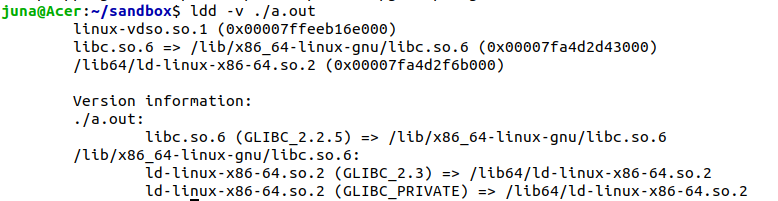

В системе GNU Linux(Ubuntu 20.04) x86-64 динамический компоновщик имеет название **/lib64/ld-linux-x86-64.so.2**.

Тогда линковка будет включать в себя:

> ld example2.o -lc -dynamic-linker /lib64/ld-linux-x86-64.so.2 -o example2

Здесь мы указываем, что нужно использовать динамический компоновщик, а также штатную библиотеку C.

Пример создания исполняемого файла из example2.asm и его использования показан на скриншоте ниже.

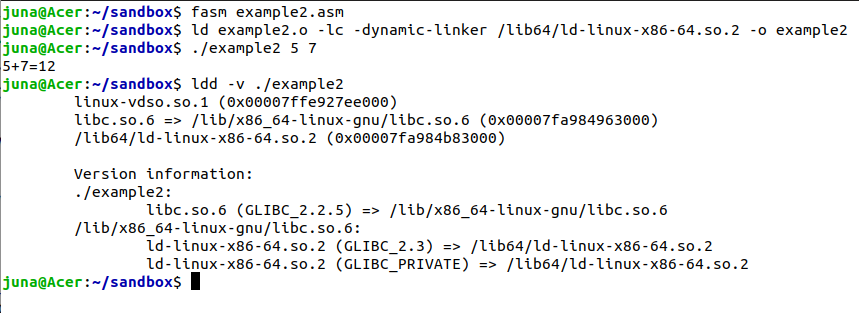

Если осуществлять линковку с помощью gcc, то вместо точки входа **\_start**, необходимо указывать **main**. При этом **main** является функцией и параметры командной строки передаются в нее в соответствии с соглашениями передачи параметров в функцию: первый параметр **argc** записывается в **rdi**, все последующие параметры: **\*argv** - в **rsi** с шагом через 8 байт. Важным вопросом здесь является выравнивание стека до 16 байт. Дело в том, что поскольку **main** - это функция, то адрес возврата лежит в вершине стека и адрес вершины стека не делится на 16, а для вызова любой C функции действует соглашение о выравнивании стека по границе 16 байт. Поэтому вызов функции printf из main без дополнительных действий по выравниванию стека приведет к нарушению сегментации. Чаще всего выравнивание можно сделать простым вычитанием из регистра **rsp** значения 8 с последующим добавлением к **rsp** значения 8 перед возвратом из main с помощью **ret**. 

В приведенной ниже программе учитываются все эти особенности.

In [ ]:
;;example3.asm
format elf64

	public main

	extrn printf
	extrn atoi

	section '.data' writable

	msg db "%d+%d=%d", 0xa, 0

	
main:
	sub rsp,8 		;выравниваем стек по границе 16 байт

	mov r12, [rsi+8]		;сохраняем адрес первого параметра
	mov r13, [rsi+16]		;сохраняем адрес второго параметра
	mov rdi, r12		;превращает первый параметр в число
	call atoi
	mov r12, rax		;сохраняем первый параметр
	mov rdi, r13		;превращаем второй параметр в число
	call atoi
	mov r13, rax		;сохраняем второй параметр
	mov rsi, r12		;готовим параметры для printf
	mov rdx, r13		;готовим параметры для printf
	add r12, r13 		;выполняем суммирование
	mov rcx, r12
	mov rdi, msg 		;готовим параметры для printf
	call printf 		;вызываем printf
	add rsp, 8		;возвращаем значение указателя стека
	ret

Ниже представлен скриншот, в котором демонстрируется использование всех вариантов создания исполняемых файлов. При ключевом слове --static компилятора gcc создается статическая библиотека, загружаемая непосредственно в сам исполняемый файл.

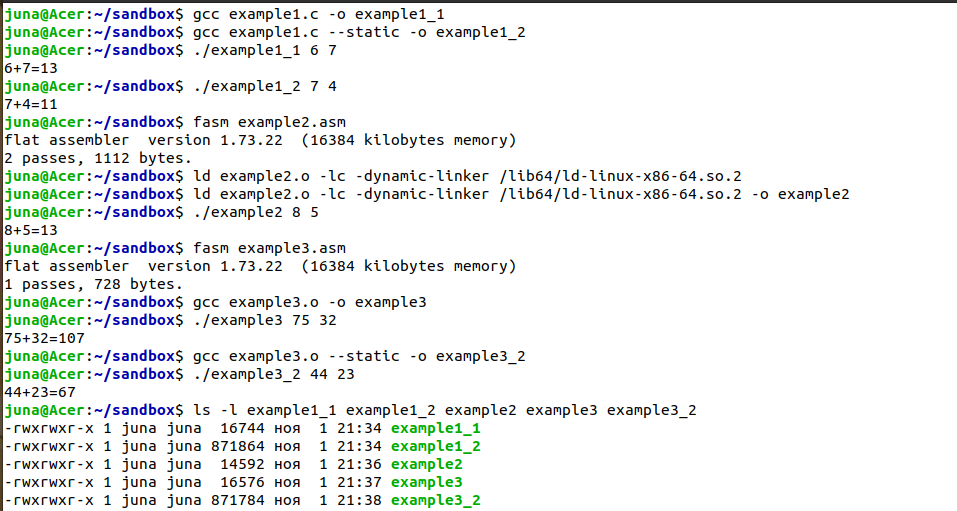

Из скриншота видно, что все программы работают исправно, при этом линковщик ld дает исполняемый файл наименьшего объема. Заметим также, что статическая линковка приводит к существенному увеличению объемов исполняемого файла.

Следует отметить, что созданные файлы могут быть существенно переработаны компоновщиком с них, как правило, появится много новых разделов. Для дизассемблирования файла на лету удобно использовать утилиту **objdump**

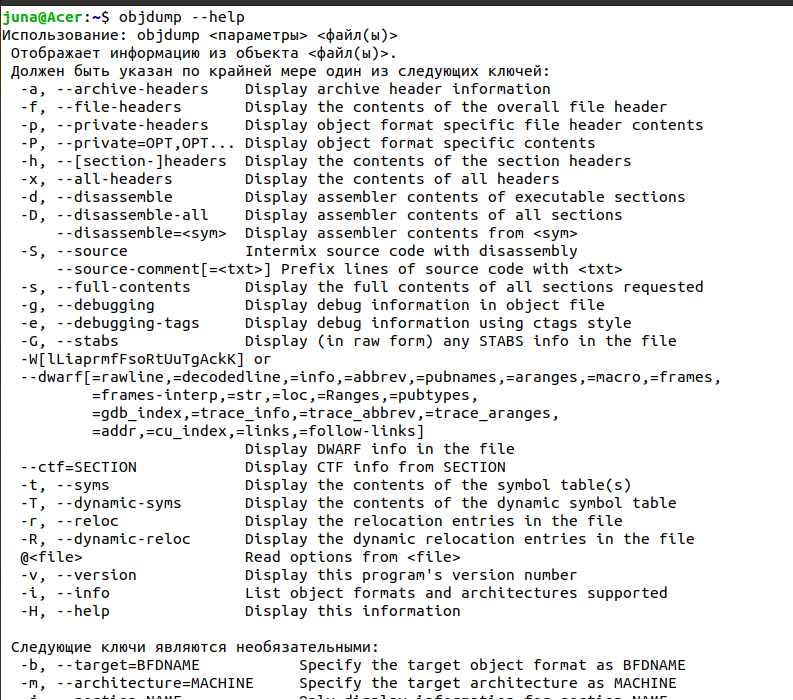

Например, ниже показано дизассемблирование файла example3:

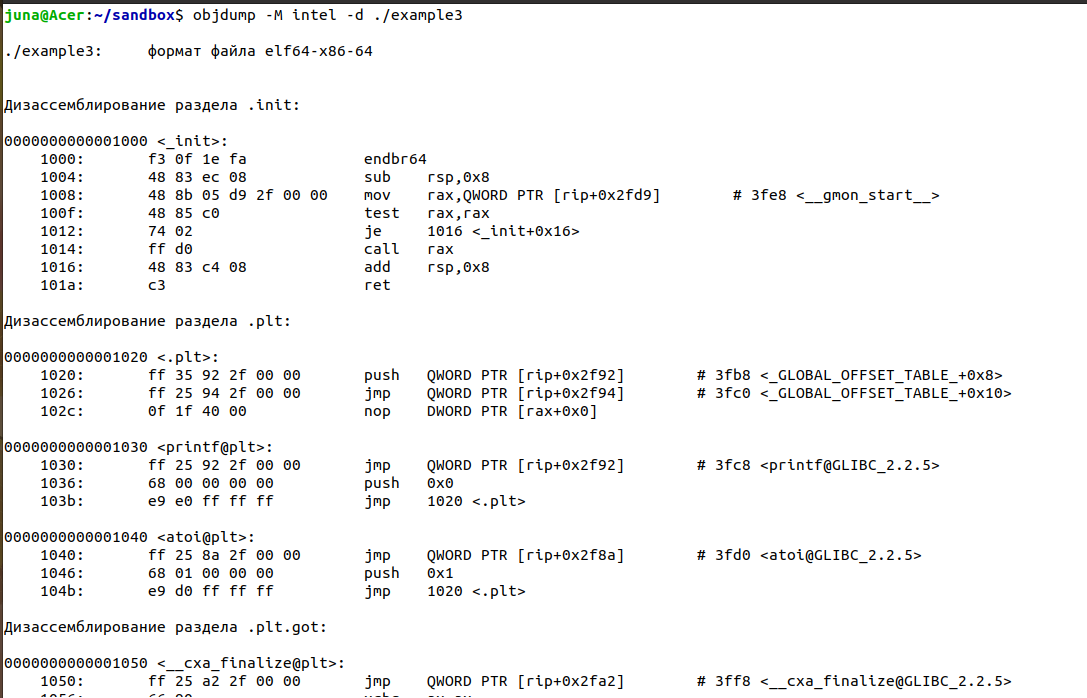

Полный состав дизассемблированного кода показан ниже:

In [ ]:
objdump -M intel -D ./example3

./example3:     формат файла elf64-x86-64


Дизассемблирование раздела .interp:

00000000000002a8 <.interp>:
 2a8:	2f                   	(bad)  
 2a9:	6c                   	ins    BYTE PTR es:[rdi],dx
 2aa:	69 62 36 34 2f 6c 64 	imul   esp,DWORD PTR [rdx+0x36],0x646c2f34
 2b1:	2d 6c 69 6e 75       	sub    eax,0x756e696c
 2b6:	78 2d                	js     2e5 <_init-0xd1b>
 2b8:	78 38                	js     2f2 <_init-0xd0e>
 2ba:	36 2d 36 34 2e 73    	ss sub eax,0x732e3436
 2c0:	6f                   	outs   dx,DWORD PTR ds:[rsi]
 2c1:	2e 32 00             	xor    al,BYTE PTR cs:[rax]

Дизассемблирование раздела .note.gnu.build-id:

00000000000002c4 <.note.gnu.build-id>:
 2c4:	04 00                	add    al,0x0
 2c6:	00 00                	add    BYTE PTR [rax],al
 2c8:	14 00                	adc    al,0x0
 2ca:	00 00                	add    BYTE PTR [rax],al
 2cc:	03 00                	add    eax,DWORD PTR [rax]
 2ce:	00 00                	add    BYTE PTR [rax],al
 2d0:	47                   	rex.RXB
 2d1:	4e 55                	rex.WRX push rbp
 2d3:	00 37                	add    BYTE PTR [rdi],dh
 2d5:	23 d2                	and    edx,edx
 2d7:	80 7a e2 6e          	cmp    BYTE PTR [rdx-0x1e],0x6e
 2db:	fe                   	(bad)  
 2dc:	a2 bf c0 f8 27 63 8f 	movabs ds:0xd1208f6327f8c0bf,al
 2e3:	20 d1 
 2e5:	cd 45                	int    0x45
 2e7:	67                   	addr32

Дизассемблирование раздела .note.ABI-tag:

00000000000002e8 <.note.ABI-tag>:
 2e8:	04 00                	add    al,0x0
 2ea:	00 00                	add    BYTE PTR [rax],al
 2ec:	10 00                	adc    BYTE PTR [rax],al
 2ee:	00 00                	add    BYTE PTR [rax],al
 2f0:	01 00                	add    DWORD PTR [rax],eax
 2f2:	00 00                	add    BYTE PTR [rax],al
 2f4:	47                   	rex.RXB
 2f5:	4e 55                	rex.WRX push rbp
 2f7:	00 00                	add    BYTE PTR [rax],al
 2f9:	00 00                	add    BYTE PTR [rax],al
 2fb:	00 03                	add    BYTE PTR [rbx],al
 2fd:	00 00                	add    BYTE PTR [rax],al
 2ff:	00 02                	add    BYTE PTR [rdx],al
 301:	00 00                	add    BYTE PTR [rax],al
 303:	00 00                	add    BYTE PTR [rax],al
 305:	00 00                	add    BYTE PTR [rax],al
	...

Дизассемблирование раздела .gnu.hash:

0000000000000308 <.gnu.hash>:
 308:	03 00                	add    eax,DWORD PTR [rax]
 30a:	00 00                	add    BYTE PTR [rax],al
 30c:	05 00 00 00 01       	add    eax,0x1000000
 311:	00 00                	add    BYTE PTR [rax],al
 313:	00 06                	add    BYTE PTR [rsi],al
 315:	00 00                	add    BYTE PTR [rax],al
 317:	00 00                	add    BYTE PTR [rax],al
 319:	00 81 00 00 40 06    	add    BYTE PTR [rcx+0x6400000],al
 31f:	01 05 00 00 00 06    	add    DWORD PTR [rip+0x6000000],eax        # 6000325 <__TMC_END__+0x5ffc2c5>
 325:	00 00                	add    BYTE PTR [rax],al
 327:	00 07                	add    BYTE PTR [rdi],al
 329:	00 00                	add    BYTE PTR [rax],al
 32b:	00 d1                	add    cl,dl
 32d:	65 ce                	gs (bad) 
 32f:	6d                   	ins    DWORD PTR es:[rdi],dx
 330:	b9 2b 6b 15 73       	mov    ecx,0x73156b2b
 335:	3c 94                	cmp    al,0x94
 337:	7c                   	.byte 0x7c

Дизассемблирование раздела .dynsym:

0000000000000338 <.dynsym>:
	...
 350:	44 00 00             	add    BYTE PTR [rax],r8b
 353:	00 20                	add    BYTE PTR [rax],ah
	...
 365:	00 00                	add    BYTE PTR [rax],al
 367:	00 26                	add    BYTE PTR [rsi],ah
 369:	00 00                	add    BYTE PTR [rax],al
 36b:	00 12                	add    BYTE PTR [rdx],dl
	...
 37d:	00 00                	add    BYTE PTR [rax],al
 37f:	00 60 00             	add    BYTE PTR [rax+0x0],ah
 382:	00 00                	add    BYTE PTR [rax],al
 384:	20 00                	and    BYTE PTR [rax],al
	...
 396:	00 00                	add    BYTE PTR [rax],al
 398:	6f                   	outs   dx,DWORD PTR ds:[rsi]
 399:	00 00                	add    BYTE PTR [rax],al
 39b:	00 20                	add    BYTE PTR [rax],ah
	...
 3ad:	00 00                	add    BYTE PTR [rax],al
 3af:	00 17                	add    BYTE PTR [rdi],dl
 3b1:	00 00                	add    BYTE PTR [rax],al
 3b3:	00 22                	add    BYTE PTR [rdx],ah
	...
 3c5:	00 00                	add    BYTE PTR [rax],al
 3c7:	00 0b                	add    BYTE PTR [rbx],cl
 3c9:	00 00                	add    BYTE PTR [rax],al
 3cb:	00 12                	add    BYTE PTR [rdx],dl
 3cd:	00 00                	add    BYTE PTR [rax],al
 3cf:	00 30                	add    BYTE PTR [rax],dh
 3d1:	10 00                	adc    BYTE PTR [rax],al
	...
 3df:	00 12                	add    BYTE PTR [rdx],dl
 3e1:	00 00                	add    BYTE PTR [rax],al
 3e3:	00 12                	add    BYTE PTR [rdx],dl
 3e5:	00 00                	add    BYTE PTR [rax],al
 3e7:	00 40 10             	add    BYTE PTR [rax+0x10],al
	...

Дизассемблирование раздела .dynstr:

00000000000003f8 <.dynstr>:
 3f8:	00 6c 69 62          	add    BYTE PTR [rcx+rbp*2+0x62],ch
 3fc:	63 2e                	movsxd ebp,DWORD PTR [rsi]
 3fe:	73 6f                	jae    46f <_init-0xb91>
 400:	2e 36 00 70 72       	cs add BYTE PTR ss:[rax+0x72],dh
 405:	69 6e 74 66 00 61 74 	imul   ebp,DWORD PTR [rsi+0x74],0x74610066
 40c:	6f                   	outs   dx,DWORD PTR ds:[rsi]
 40d:	69 00 5f 5f 63 78    	imul   eax,DWORD PTR [rax],0x78635f5f
 413:	61                   	(bad)  
 414:	5f                   	pop    rdi
 415:	66 69 6e 61 6c 69    	imul   bp,WORD PTR [rsi+0x61],0x696c
 41b:	7a 65                	jp     482 <_init-0xb7e>
 41d:	00 5f 5f             	add    BYTE PTR [rdi+0x5f],bl
 420:	6c                   	ins    BYTE PTR es:[rdi],dx
 421:	69 62 63 5f 73 74 61 	imul   esp,DWORD PTR [rdx+0x63],0x6174735f
 428:	72 74                	jb     49e <_init-0xb62>
 42a:	5f                   	pop    rdi
 42b:	6d                   	ins    DWORD PTR es:[rdi],dx
 42c:	61                   	(bad)  
 42d:	69 6e 00 47 4c 49 42 	imul   ebp,DWORD PTR [rsi+0x0],0x42494c47
 434:	43 5f                	rex.XB pop r15
 436:	32 2e                	xor    ch,BYTE PTR [rsi]
 438:	32 2e                	xor    ch,BYTE PTR [rsi]
 43a:	35 00 5f 49 54       	xor    eax,0x54495f00
 43f:	4d 5f                	rex.WRB pop r15
 441:	64 65 72 65          	fs gs jb 4aa <_init-0xb56>
 445:	67 69 73 74 65 72 54 	imul   esi,DWORD PTR [ebx+0x74],0x4d547265
 44c:	4d 
 44d:	43 6c                	rex.XB ins BYTE PTR es:[rdi],dx
 44f:	6f                   	outs   dx,DWORD PTR ds:[rsi]
 450:	6e                   	outs   dx,BYTE PTR ds:[rsi]
 451:	65 54                	gs push rsp
 453:	61                   	(bad)  
 454:	62                   	(bad)  
 455:	6c                   	ins    BYTE PTR es:[rdi],dx
 456:	65 00 5f 5f          	add    BYTE PTR gs:[rdi+0x5f],bl
 45a:	67 6d                	ins    DWORD PTR es:[edi],dx
 45c:	6f                   	outs   dx,DWORD PTR ds:[rsi]
 45d:	6e                   	outs   dx,BYTE PTR ds:[rsi]
 45e:	5f                   	pop    rdi
 45f:	73 74                	jae    4d5 <_init-0xb2b>
 461:	61                   	(bad)  
 462:	72 74                	jb     4d8 <_init-0xb28>
 464:	5f                   	pop    rdi
 465:	5f                   	pop    rdi
 466:	00 5f 49             	add    BYTE PTR [rdi+0x49],bl
 469:	54                   	push   rsp
 46a:	4d 5f                	rex.WRB pop r15
 46c:	72 65                	jb     4d3 <_init-0xb2d>
 46e:	67 69 73 74 65 72 54 	imul   esi,DWORD PTR [ebx+0x74],0x4d547265
 475:	4d 
 476:	43 6c                	rex.XB ins BYTE PTR es:[rdi],dx
 478:	6f                   	outs   dx,DWORD PTR ds:[rsi]
 479:	6e                   	outs   dx,BYTE PTR ds:[rsi]
 47a:	65 54                	gs push rsp
 47c:	61                   	(bad)  
 47d:	62                   	.byte 0x62
 47e:	6c                   	ins    BYTE PTR es:[rdi],dx
 47f:	65                   	gs
	...

Дизассемблирование раздела .gnu.version:

0000000000000482 <.gnu.version>:
 482:	00 00                	add    BYTE PTR [rax],al
 484:	00 00                	add    BYTE PTR [rax],al
 486:	02 00                	add    al,BYTE PTR [rax]
 488:	00 00                	add    BYTE PTR [rax],al
 48a:	00 00                	add    BYTE PTR [rax],al
 48c:	02 00                	add    al,BYTE PTR [rax]
 48e:	02 00                	add    al,BYTE PTR [rax]
 490:	02 00                	add    al,BYTE PTR [rax]

Дизассемблирование раздела .gnu.version_r:

0000000000000498 <.gnu.version_r>:
 498:	01 00                	add    DWORD PTR [rax],eax
 49a:	01 00                	add    DWORD PTR [rax],eax
 49c:	01 00                	add    DWORD PTR [rax],eax
 49e:	00 00                	add    BYTE PTR [rax],al
 4a0:	10 00                	adc    BYTE PTR [rax],al
 4a2:	00 00                	add    BYTE PTR [rax],al
 4a4:	00 00                	add    BYTE PTR [rax],al
 4a6:	00 00                	add    BYTE PTR [rax],al
 4a8:	75 1a                	jne    4c4 <_init-0xb3c>
 4aa:	69 09 00 00 02 00    	imul   ecx,DWORD PTR [rcx],0x20000
 4b0:	38 00                	cmp    BYTE PTR [rax],al
 4b2:	00 00                	add    BYTE PTR [rax],al
 4b4:	00 00                	add    BYTE PTR [rax],al
	...

Дизассемблирование раздела .rela.dyn:

00000000000004b8 <.rela.dyn>:
 4b8:	b0 3d                	mov    al,0x3d
 4ba:	00 00                	add    BYTE PTR [rax],al
 4bc:	00 00                	add    BYTE PTR [rax],al
 4be:	00 00                	add    BYTE PTR [rax],al
 4c0:	08 00                	or     BYTE PTR [rax],al
 4c2:	00 00                	add    BYTE PTR [rax],al
 4c4:	00 00                	add    BYTE PTR [rax],al
 4c6:	00 00                	add    BYTE PTR [rax],al
 4c8:	40 11 00             	rex adc DWORD PTR [rax],eax
 4cb:	00 00                	add    BYTE PTR [rax],al
 4cd:	00 00                	add    BYTE PTR [rax],al
 4cf:	00 b8 3d 00 00 00    	add    BYTE PTR [rax+0x3d],bh
 4d5:	00 00                	add    BYTE PTR [rax],al
 4d7:	00 08                	add    BYTE PTR [rax],cl
	...
 4e1:	11 00                	adc    DWORD PTR [rax],eax
 4e3:	00 00                	add    BYTE PTR [rax],al
 4e5:	00 00                	add    BYTE PTR [rax],al
 4e7:	00 08                	add    BYTE PTR [rax],cl
 4e9:	40 00 00             	add    BYTE PTR [rax],al
 4ec:	00 00                	add    BYTE PTR [rax],al
 4ee:	00 00                	add    BYTE PTR [rax],al
 4f0:	08 00                	or     BYTE PTR [rax],al
 4f2:	00 00                	add    BYTE PTR [rax],al
 4f4:	00 00                	add    BYTE PTR [rax],al
 4f6:	00 00                	add    BYTE PTR [rax],al
 4f8:	08 40 00             	or     BYTE PTR [rax+0x0],al
 4fb:	00 00                	add    BYTE PTR [rax],al
 4fd:	00 00                	add    BYTE PTR [rax],al
 4ff:	00 4a 40             	add    BYTE PTR [rdx+0x40],cl
 502:	00 00                	add    BYTE PTR [rax],al
 504:	00 00                	add    BYTE PTR [rax],al
 506:	00 00                	add    BYTE PTR [rax],al
 508:	08 00                	or     BYTE PTR [rax],al
 50a:	00 00                	add    BYTE PTR [rax],al
 50c:	00 00                	add    BYTE PTR [rax],al
 50e:	00 00                	add    BYTE PTR [rax],al
 510:	10 40 00             	adc    BYTE PTR [rax+0x0],al
 513:	00 00                	add    BYTE PTR [rax],al
 515:	00 00                	add    BYTE PTR [rax],al
 517:	00 d8                	add    al,bl
 519:	3f                   	(bad)  
 51a:	00 00                	add    BYTE PTR [rax],al
 51c:	00 00                	add    BYTE PTR [rax],al
 51e:	00 00                	add    BYTE PTR [rax],al
 520:	06                   	(bad)  
 521:	00 00                	add    BYTE PTR [rax],al
 523:	00 01                	add    BYTE PTR [rcx],al
	...
 52d:	00 00                	add    BYTE PTR [rax],al
 52f:	00 e0                	add    al,ah
 531:	3f                   	(bad)  
 532:	00 00                	add    BYTE PTR [rax],al
 534:	00 00                	add    BYTE PTR [rax],al
 536:	00 00                	add    BYTE PTR [rax],al
 538:	06                   	(bad)  
 539:	00 00                	add    BYTE PTR [rax],al
 53b:	00 02                	add    BYTE PTR [rdx],al
	...
 545:	00 00                	add    BYTE PTR [rax],al
 547:	00 e8                	add    al,ch
 549:	3f                   	(bad)  
 54a:	00 00                	add    BYTE PTR [rax],al
 54c:	00 00                	add    BYTE PTR [rax],al
 54e:	00 00                	add    BYTE PTR [rax],al
 550:	06                   	(bad)  
 551:	00 00                	add    BYTE PTR [rax],al
 553:	00 03                	add    BYTE PTR [rbx],al
	...
 55d:	00 00                	add    BYTE PTR [rax],al
 55f:	00 f0                	add    al,dh
 561:	3f                   	(bad)  
 562:	00 00                	add    BYTE PTR [rax],al
 564:	00 00                	add    BYTE PTR [rax],al
 566:	00 00                	add    BYTE PTR [rax],al
 568:	06                   	(bad)  
 569:	00 00                	add    BYTE PTR [rax],al
 56b:	00 04 00             	add    BYTE PTR [rax+rax*1],al
	...
 576:	00 00                	add    BYTE PTR [rax],al
 578:	f8                   	clc    
 579:	3f                   	(bad)  
 57a:	00 00                	add    BYTE PTR [rax],al
 57c:	00 00                	add    BYTE PTR [rax],al
 57e:	00 00                	add    BYTE PTR [rax],al
 580:	06                   	(bad)  
 581:	00 00                	add    BYTE PTR [rax],al
 583:	00 05 00 00 00 00    	add    BYTE PTR [rip+0x0],al        # 589 <_init-0xa77>
 589:	00 00                	add    BYTE PTR [rax],al
 58b:	00 00                	add    BYTE PTR [rax],al
 58d:	00 00                	add    BYTE PTR [rax],al
	...

Дизассемблирование раздела .rela.plt:

0000000000000590 <.rela.plt>:
 590:	c8 3f 00 00          	enter  0x3f,0x0
 594:	00 00                	add    BYTE PTR [rax],al
 596:	00 00                	add    BYTE PTR [rax],al
 598:	07                   	(bad)  
 599:	00 00                	add    BYTE PTR [rax],al
 59b:	00 06                	add    BYTE PTR [rsi],al
	...
 5a5:	00 00                	add    BYTE PTR [rax],al
 5a7:	00 d0                	add    al,dl
 5a9:	3f                   	(bad)  
 5aa:	00 00                	add    BYTE PTR [rax],al
 5ac:	00 00                	add    BYTE PTR [rax],al
 5ae:	00 00                	add    BYTE PTR [rax],al
 5b0:	07                   	(bad)  
 5b1:	00 00                	add    BYTE PTR [rax],al
 5b3:	00 07                	add    BYTE PTR [rdi],al
	...

Дизассемблирование раздела .init:

0000000000001000 <_init>:
    1000:	f3 0f 1e fa          	endbr64 
    1004:	48 83 ec 08          	sub    rsp,0x8
    1008:	48 8b 05 d9 2f 00 00 	mov    rax,QWORD PTR [rip+0x2fd9]        # 3fe8 <__gmon_start__>
    100f:	48 85 c0             	test   rax,rax
    1012:	74 02                	je     1016 <_init+0x16>
    1014:	ff d0                	call   rax
    1016:	48 83 c4 08          	add    rsp,0x8
    101a:	c3                   	ret    

Дизассемблирование раздела .plt:

0000000000001020 <.plt>:
    1020:	ff 35 92 2f 00 00    	push   QWORD PTR [rip+0x2f92]        # 3fb8 <_GLOBAL_OFFSET_TABLE_+0x8>
    1026:	ff 25 94 2f 00 00    	jmp    QWORD PTR [rip+0x2f94]        # 3fc0 <_GLOBAL_OFFSET_TABLE_+0x10>
    102c:	0f 1f 40 00          	nop    DWORD PTR [rax+0x0]

0000000000001030 <printf@plt>:
    1030:	ff 25 92 2f 00 00    	jmp    QWORD PTR [rip+0x2f92]        # 3fc8 <printf@GLIBC_2.2.5>
    1036:	68 00 00 00 00       	push   0x0
    103b:	e9 e0 ff ff ff       	jmp    1020 <.plt>

0000000000001040 <atoi@plt>:
    1040:	ff 25 8a 2f 00 00    	jmp    QWORD PTR [rip+0x2f8a]        # 3fd0 <atoi@GLIBC_2.2.5>
    1046:	68 01 00 00 00       	push   0x1
    104b:	e9 d0 ff ff ff       	jmp    1020 <.plt>

Дизассемблирование раздела .plt.got:

0000000000001050 <__cxa_finalize@plt>:
    1050:	ff 25 a2 2f 00 00    	jmp    QWORD PTR [rip+0x2fa2]        # 3ff8 <__cxa_finalize@GLIBC_2.2.5>
    1056:	66 90                	xchg   ax,ax

Дизассемблирование раздела .text:

0000000000001060 <_start>:
    1060:	f3 0f 1e fa          	endbr64 
    1064:	31 ed                	xor    ebp,ebp
    1066:	49 89 d1             	mov    r9,rdx
    1069:	5e                   	pop    rsi
    106a:	48 89 e2             	mov    rdx,rsp
    106d:	48 83 e4 f0          	and    rsp,0xfffffffffffffff0
    1071:	50                   	push   rax
    1072:	54                   	push   rsp
    1073:	4c 8d 05 46 01 00 00 	lea    r8,[rip+0x146]        # 11c0 <__libc_csu_fini>
    107a:	48 8d 0d cf 00 00 00 	lea    rcx,[rip+0xcf]        # 1150 <__libc_csu_init>
    1081:	48 8d 3d 92 2f 00 00 	lea    rdi,[rip+0x2f92]        # 401a <main>
    1088:	ff 15 52 2f 00 00    	call   QWORD PTR [rip+0x2f52]        # 3fe0 <__libc_start_main@GLIBC_2.2.5>
    108e:	f4                   	hlt    
    108f:	90                   	nop

0000000000001090 <deregister_tm_clones>:
    1090:	48 8d 3d c9 2f 00 00 	lea    rdi,[rip+0x2fc9]        # 4060 <__TMC_END__>
    1097:	48 8d 05 c2 2f 00 00 	lea    rax,[rip+0x2fc2]        # 4060 <__TMC_END__>
    109e:	48 39 f8             	cmp    rax,rdi
    10a1:	74 15                	je     10b8 <deregister_tm_clones+0x28>
    10a3:	48 8b 05 2e 2f 00 00 	mov    rax,QWORD PTR [rip+0x2f2e]        # 3fd8 <_ITM_deregisterTMCloneTable>
    10aa:	48 85 c0             	test   rax,rax
    10ad:	74 09                	je     10b8 <deregister_tm_clones+0x28>
    10af:	ff e0                	jmp    rax
    10b1:	0f 1f 80 00 00 00 00 	nop    DWORD PTR [rax+0x0]
    10b8:	c3                   	ret    
    10b9:	0f 1f 80 00 00 00 00 	nop    DWORD PTR [rax+0x0]

00000000000010c0 <register_tm_clones>:
    10c0:	48 8d 3d 99 2f 00 00 	lea    rdi,[rip+0x2f99]        # 4060 <__TMC_END__>
    10c7:	48 8d 35 92 2f 00 00 	lea    rsi,[rip+0x2f92]        # 4060 <__TMC_END__>
    10ce:	48 29 fe             	sub    rsi,rdi
    10d1:	48 89 f0             	mov    rax,rsi
    10d4:	48 c1 ee 3f          	shr    rsi,0x3f
    10d8:	48 c1 f8 03          	sar    rax,0x3
    10dc:	48 01 c6             	add    rsi,rax
    10df:	48 d1 fe             	sar    rsi,1
    10e2:	74 14                	je     10f8 <register_tm_clones+0x38>
    10e4:	48 8b 05 05 2f 00 00 	mov    rax,QWORD PTR [rip+0x2f05]        # 3ff0 <_ITM_registerTMCloneTable>
    10eb:	48 85 c0             	test   rax,rax
    10ee:	74 08                	je     10f8 <register_tm_clones+0x38>
    10f0:	ff e0                	jmp    rax
    10f2:	66 0f 1f 44 00 00    	nop    WORD PTR [rax+rax*1+0x0]
    10f8:	c3                   	ret    
    10f9:	0f 1f 80 00 00 00 00 	nop    DWORD PTR [rax+0x0]

0000000000001100 <__do_global_dtors_aux>:
    1100:	f3 0f 1e fa          	endbr64 
    1104:	80 3d 51 2f 00 00 00 	cmp    BYTE PTR [rip+0x2f51],0x0        # 405c <completed.8061>
    110b:	75 2b                	jne    1138 <__do_global_dtors_aux+0x38>
    110d:	55                   	push   rbp
    110e:	48 83 3d e2 2e 00 00 	cmp    QWORD PTR [rip+0x2ee2],0x0        # 3ff8 <__cxa_finalize@GLIBC_2.2.5>
    1115:	00 
    1116:	48 89 e5             	mov    rbp,rsp
    1119:	74 0c                	je     1127 <__do_global_dtors_aux+0x27>
    111b:	48 8b 3d e6 2e 00 00 	mov    rdi,QWORD PTR [rip+0x2ee6]        # 4008 <__dso_handle>
    1122:	e8 29 ff ff ff       	call   1050 <__cxa_finalize@plt>
    1127:	e8 64 ff ff ff       	call   1090 <deregister_tm_clones>
    112c:	c6 05 29 2f 00 00 01 	mov    BYTE PTR [rip+0x2f29],0x1        # 405c <completed.8061>
    1133:	5d                   	pop    rbp
    1134:	c3                   	ret    
    1135:	0f 1f 00             	nop    DWORD PTR [rax]
    1138:	c3                   	ret    
    1139:	0f 1f 80 00 00 00 00 	nop    DWORD PTR [rax+0x0]

0000000000001140 <frame_dummy>:
    1140:	f3 0f 1e fa          	endbr64 
    1144:	e9 77 ff ff ff       	jmp    10c0 <register_tm_clones>
    1149:	0f 1f 80 00 00 00 00 	nop    DWORD PTR [rax+0x0]

0000000000001150 <__libc_csu_init>:
    1150:	f3 0f 1e fa          	endbr64 
    1154:	41 57                	push   r15
    1156:	4c 8d 3d 53 2c 00 00 	lea    r15,[rip+0x2c53]        # 3db0 <__frame_dummy_init_array_entry>
    115d:	41 56                	push   r14
    115f:	49 89 d6             	mov    r14,rdx
    1162:	41 55                	push   r13
    1164:	49 89 f5             	mov    r13,rsi
    1167:	41 54                	push   r12
    1169:	41 89 fc             	mov    r12d,edi
    116c:	55                   	push   rbp
    116d:	48 8d 2d 44 2c 00 00 	lea    rbp,[rip+0x2c44]        # 3db8 <__do_global_dtors_aux_fini_array_entry>
    1174:	53                   	push   rbx
    1175:	4c 29 fd             	sub    rbp,r15
    1178:	48 83 ec 08          	sub    rsp,0x8
    117c:	e8 7f fe ff ff       	call   1000 <_init>
    1181:	48 c1 fd 03          	sar    rbp,0x3
    1185:	74 1f                	je     11a6 <__libc_csu_init+0x56>
    1187:	31 db                	xor    ebx,ebx
    1189:	0f 1f 80 00 00 00 00 	nop    DWORD PTR [rax+0x0]
    1190:	4c 89 f2             	mov    rdx,r14
    1193:	4c 89 ee             	mov    rsi,r13
    1196:	44 89 e7             	mov    edi,r12d
    1199:	41 ff 14 df          	call   QWORD PTR [r15+rbx*8]
    119d:	48 83 c3 01          	add    rbx,0x1
    11a1:	48 39 dd             	cmp    rbp,rbx
    11a4:	75 ea                	jne    1190 <__libc_csu_init+0x40>
    11a6:	48 83 c4 08          	add    rsp,0x8
    11aa:	5b                   	pop    rbx
    11ab:	5d                   	pop    rbp
    11ac:	41 5c                	pop    r12
    11ae:	41 5d                	pop    r13
    11b0:	41 5e                	pop    r14
    11b2:	41 5f                	pop    r15
    11b4:	c3                   	ret    
    11b5:	66 66 2e 0f 1f 84 00 	data16 nop WORD PTR cs:[rax+rax*1+0x0]
    11bc:	00 00 00 00 

00000000000011c0 <__libc_csu_fini>:
    11c0:	f3 0f 1e fa          	endbr64 
    11c4:	c3                   	ret    

Дизассемблирование раздела .fini:

00000000000011c8 <_fini>:
    11c8:	f3 0f 1e fa          	endbr64 
    11cc:	48 83 ec 08          	sub    rsp,0x8
    11d0:	48 83 c4 08          	add    rsp,0x8
    11d4:	c3                   	ret    

Дизассемблирование раздела .rodata:

0000000000002000 <_IO_stdin_used>:
    2000:	01 00                	add    DWORD PTR [rax],eax
    2002:	02 00                	add    al,BYTE PTR [rax]

Дизассемблирование раздела .eh_frame_hdr:

0000000000002004 <__GNU_EH_FRAME_HDR>:
    2004:	01 1b                	add    DWORD PTR [rbx],ebx
    2006:	03 3b                	add    edi,DWORD PTR [rbx]
    2008:	30 00                	xor    BYTE PTR [rax],al
    200a:	00 00                	add    BYTE PTR [rax],al
    200c:	05 00 00 00 1c       	add    eax,0x1c000000
    2011:	f0 ff                	lock (bad) 
    2013:	ff 64 00 00          	jmp    QWORD PTR [rax+rax*1+0x0]
    2017:	00 4c f0 ff          	add    BYTE PTR [rax+rsi*8-0x1],cl
    201b:	ff 8c 00 00 00 5c f0 	dec    DWORD PTR [rax+rax*1-0xfa40000]
    2022:	ff                   	(bad)  
    2023:	ff 4c 00 00          	dec    DWORD PTR [rax+rax*1+0x0]
    2027:	00 4c f1 ff          	add    BYTE PTR [rcx+rsi*8-0x1],cl
    202b:	ff a4 00 00 00 bc f1 	jmp    QWORD PTR [rax+rax*1-0xe440000]
    2032:	ff                   	(bad)  
    2033:	ff                   	(bad)  
    2034:	ec                   	in     al,dx
    2035:	00 00                	add    BYTE PTR [rax],al
	...

Дизассемблирование раздела .eh_frame:

0000000000002038 <__FRAME_END__-0xcc>:
    2038:	14 00                	adc    al,0x0
    203a:	00 00                	add    BYTE PTR [rax],al
    203c:	00 00                	add    BYTE PTR [rax],al
    203e:	00 00                	add    BYTE PTR [rax],al
    2040:	01 7a 52             	add    DWORD PTR [rdx+0x52],edi
    2043:	00 01                	add    BYTE PTR [rcx],al
    2045:	78 10                	js     2057 <__GNU_EH_FRAME_HDR+0x53>
    2047:	01 1b                	add    DWORD PTR [rbx],ebx
    2049:	0c 07                	or     al,0x7
    204b:	08 90 01 00 00 14    	or     BYTE PTR [rax+0x14000001],dl
    2051:	00 00                	add    BYTE PTR [rax],al
    2053:	00 1c 00             	add    BYTE PTR [rax+rax*1],bl
    2056:	00 00                	add    BYTE PTR [rax],al
    2058:	08 f0                	or     al,dh
    205a:	ff                   	(bad)  
    205b:	ff 2f                	jmp    FWORD PTR [rdi]
    205d:	00 00                	add    BYTE PTR [rax],al
    205f:	00 00                	add    BYTE PTR [rax],al
    2061:	44 07                	rex.R (bad) 
    2063:	10 00                	adc    BYTE PTR [rax],al
    2065:	00 00                	add    BYTE PTR [rax],al
    2067:	00 24 00             	add    BYTE PTR [rax+rax*1],ah
    206a:	00 00                	add    BYTE PTR [rax],al
    206c:	34 00                	xor    al,0x0
    206e:	00 00                	add    BYTE PTR [rax],al
    2070:	b0 ef                	mov    al,0xef
    2072:	ff                   	(bad)  
    2073:	ff 30                	push   QWORD PTR [rax]
    2075:	00 00                	add    BYTE PTR [rax],al
    2077:	00 00                	add    BYTE PTR [rax],al
    2079:	0e                   	(bad)  
    207a:	10 46 0e             	adc    BYTE PTR [rsi+0xe],al
    207d:	18 4a 0f             	sbb    BYTE PTR [rdx+0xf],cl
    2080:	0b 77 08             	or     esi,DWORD PTR [rdi+0x8]
    2083:	80 00 3f             	add    BYTE PTR [rax],0x3f
    2086:	1a 3b                	sbb    bh,BYTE PTR [rbx]
    2088:	2a 33                	sub    dh,BYTE PTR [rbx]
    208a:	24 22                	and    al,0x22
    208c:	00 00                	add    BYTE PTR [rax],al
    208e:	00 00                	add    BYTE PTR [rax],al
    2090:	14 00                	adc    al,0x0
    2092:	00 00                	add    BYTE PTR [rax],al
    2094:	5c                   	pop    rsp
    2095:	00 00                	add    BYTE PTR [rax],al
    2097:	00 b8 ef ff ff 08    	add    BYTE PTR [rax+0x8ffffef],bh
	...
    20a5:	00 00                	add    BYTE PTR [rax],al
    20a7:	00 44 00 00          	add    BYTE PTR [rax+rax*1+0x0],al
    20ab:	00 74 00 00          	add    BYTE PTR [rax+rax*1+0x0],dh
    20af:	00 a0 f0 ff ff 65    	add    BYTE PTR [rax+0x65fffff0],ah
    20b5:	00 00                	add    BYTE PTR [rax],al
    20b7:	00 00                	add    BYTE PTR [rax],al
    20b9:	46 0e                	rex.RX (bad) 
    20bb:	10 8f 02 49 0e 18    	adc    BYTE PTR [rdi+0x180e4902],cl
    20c1:	8e 03                	mov    es,WORD PTR [rbx]
    20c3:	45 0e                	rex.RB (bad) 
    20c5:	20 8d 04 45 0e 28    	and    BYTE PTR [rbp+0x280e4504],cl
    20cb:	8c 05 44 0e 30 86    	mov    WORD PTR [rip+0xffffffff86300e44],es        # ffffffff86302f15 <__TMC_END__+0xffffffff862feeb5>
    20d1:	06                   	(bad)  
    20d2:	48 0e                	rex.W (bad) 
    20d4:	38 83 07 47 0e 40    	cmp    BYTE PTR [rbx+0x400e4707],al
    20da:	6e                   	outs   dx,BYTE PTR ds:[rsi]
    20db:	0e                   	(bad)  
    20dc:	38 41 0e             	cmp    BYTE PTR [rcx+0xe],al
    20df:	30 41 0e             	xor    BYTE PTR [rcx+0xe],al
    20e2:	28 42 0e             	sub    BYTE PTR [rdx+0xe],al
    20e5:	20 42 0e             	and    BYTE PTR [rdx+0xe],al
    20e8:	18 42 0e             	sbb    BYTE PTR [rdx+0xe],al
    20eb:	10 42 0e             	adc    BYTE PTR [rdx+0xe],al
    20ee:	08 00                	or     BYTE PTR [rax],al
    20f0:	10 00                	adc    BYTE PTR [rax],al
    20f2:	00 00                	add    BYTE PTR [rax],al
    20f4:	bc 00 00 00 c8       	mov    esp,0xc8000000
    20f9:	f0 ff                	lock (bad) 
    20fb:	ff 05 00 00 00 00    	inc    DWORD PTR [rip+0x0]        # 2101 <__GNU_EH_FRAME_HDR+0xfd>
    2101:	00 00                	add    BYTE PTR [rax],al
	...

0000000000002104 <__FRAME_END__>:
    2104:	00 00                	add    BYTE PTR [rax],al
	...

Дизассемблирование раздела .init_array:

0000000000003db0 <__frame_dummy_init_array_entry>:
    3db0:	40 11 00             	rex adc DWORD PTR [rax],eax
    3db3:	00 00                	add    BYTE PTR [rax],al
    3db5:	00 00                	add    BYTE PTR [rax],al
	...

Дизассемблирование раздела .fini_array:

0000000000003db8 <__do_global_dtors_aux_fini_array_entry>:
    3db8:	00 11                	add    BYTE PTR [rcx],dl
    3dba:	00 00                	add    BYTE PTR [rax],al
    3dbc:	00 00                	add    BYTE PTR [rax],al
	...

Дизассемблирование раздела .dynamic:

0000000000003dc0 <_DYNAMIC>:
    3dc0:	01 00                	add    DWORD PTR [rax],eax
    3dc2:	00 00                	add    BYTE PTR [rax],al
    3dc4:	00 00                	add    BYTE PTR [rax],al
    3dc6:	00 00                	add    BYTE PTR [rax],al
    3dc8:	01 00                	add    DWORD PTR [rax],eax
    3dca:	00 00                	add    BYTE PTR [rax],al
    3dcc:	00 00                	add    BYTE PTR [rax],al
    3dce:	00 00                	add    BYTE PTR [rax],al
    3dd0:	0c 00                	or     al,0x0
    3dd2:	00 00                	add    BYTE PTR [rax],al
    3dd4:	00 00                	add    BYTE PTR [rax],al
    3dd6:	00 00                	add    BYTE PTR [rax],al
    3dd8:	00 10                	add    BYTE PTR [rax],dl
    3dda:	00 00                	add    BYTE PTR [rax],al
    3ddc:	00 00                	add    BYTE PTR [rax],al
    3dde:	00 00                	add    BYTE PTR [rax],al
    3de0:	0d 00 00 00 00       	or     eax,0x0
    3de5:	00 00                	add    BYTE PTR [rax],al
    3de7:	00 c8                	add    al,cl
    3de9:	11 00                	adc    DWORD PTR [rax],eax
    3deb:	00 00                	add    BYTE PTR [rax],al
    3ded:	00 00                	add    BYTE PTR [rax],al
    3def:	00 19                	add    BYTE PTR [rcx],bl
    3df1:	00 00                	add    BYTE PTR [rax],al
    3df3:	00 00                	add    BYTE PTR [rax],al
    3df5:	00 00                	add    BYTE PTR [rax],al
    3df7:	00 b0 3d 00 00 00    	add    BYTE PTR [rax+0x3d],dh
    3dfd:	00 00                	add    BYTE PTR [rax],al
    3dff:	00 1b                	add    BYTE PTR [rbx],bl
    3e01:	00 00                	add    BYTE PTR [rax],al
    3e03:	00 00                	add    BYTE PTR [rax],al
    3e05:	00 00                	add    BYTE PTR [rax],al
    3e07:	00 08                	add    BYTE PTR [rax],cl
    3e09:	00 00                	add    BYTE PTR [rax],al
    3e0b:	00 00                	add    BYTE PTR [rax],al
    3e0d:	00 00                	add    BYTE PTR [rax],al
    3e0f:	00 1a                	add    BYTE PTR [rdx],bl
    3e11:	00 00                	add    BYTE PTR [rax],al
    3e13:	00 00                	add    BYTE PTR [rax],al
    3e15:	00 00                	add    BYTE PTR [rax],al
    3e17:	00 b8 3d 00 00 00    	add    BYTE PTR [rax+0x3d],bh
    3e1d:	00 00                	add    BYTE PTR [rax],al
    3e1f:	00 1c 00             	add    BYTE PTR [rax+rax*1],bl
    3e22:	00 00                	add    BYTE PTR [rax],al
    3e24:	00 00                	add    BYTE PTR [rax],al
    3e26:	00 00                	add    BYTE PTR [rax],al
    3e28:	08 00                	or     BYTE PTR [rax],al
    3e2a:	00 00                	add    BYTE PTR [rax],al
    3e2c:	00 00                	add    BYTE PTR [rax],al
    3e2e:	00 00                	add    BYTE PTR [rax],al
    3e30:	f5                   	cmc    
    3e31:	fe                   	(bad)  
    3e32:	ff 6f 00             	jmp    FWORD PTR [rdi+0x0]
    3e35:	00 00                	add    BYTE PTR [rax],al
    3e37:	00 08                	add    BYTE PTR [rax],cl
    3e39:	03 00                	add    eax,DWORD PTR [rax]
    3e3b:	00 00                	add    BYTE PTR [rax],al
    3e3d:	00 00                	add    BYTE PTR [rax],al
    3e3f:	00 05 00 00 00 00    	add    BYTE PTR [rip+0x0],al        # 3e45 <_DYNAMIC+0x85>
    3e45:	00 00                	add    BYTE PTR [rax],al
    3e47:	00 f8                	add    al,bh
    3e49:	03 00                	add    eax,DWORD PTR [rax]
    3e4b:	00 00                	add    BYTE PTR [rax],al
    3e4d:	00 00                	add    BYTE PTR [rax],al
    3e4f:	00 06                	add    BYTE PTR [rsi],al
    3e51:	00 00                	add    BYTE PTR [rax],al
    3e53:	00 00                	add    BYTE PTR [rax],al
    3e55:	00 00                	add    BYTE PTR [rax],al
    3e57:	00 38                	add    BYTE PTR [rax],bh
    3e59:	03 00                	add    eax,DWORD PTR [rax]
    3e5b:	00 00                	add    BYTE PTR [rax],al
    3e5d:	00 00                	add    BYTE PTR [rax],al
    3e5f:	00 0a                	add    BYTE PTR [rdx],cl
    3e61:	00 00                	add    BYTE PTR [rax],al
    3e63:	00 00                	add    BYTE PTR [rax],al
    3e65:	00 00                	add    BYTE PTR [rax],al
    3e67:	00 89 00 00 00 00    	add    BYTE PTR [rcx+0x0],cl
    3e6d:	00 00                	add    BYTE PTR [rax],al
    3e6f:	00 0b                	add    BYTE PTR [rbx],cl
    3e71:	00 00                	add    BYTE PTR [rax],al
    3e73:	00 00                	add    BYTE PTR [rax],al
    3e75:	00 00                	add    BYTE PTR [rax],al
    3e77:	00 18                	add    BYTE PTR [rax],bl
    3e79:	00 00                	add    BYTE PTR [rax],al
    3e7b:	00 00                	add    BYTE PTR [rax],al
    3e7d:	00 00                	add    BYTE PTR [rax],al
    3e7f:	00 15 00 00 00 00    	add    BYTE PTR [rip+0x0],dl        # 3e85 <_DYNAMIC+0xc5>
	...
    3e8d:	00 00                	add    BYTE PTR [rax],al
    3e8f:	00 03                	add    BYTE PTR [rbx],al
    3e91:	00 00                	add    BYTE PTR [rax],al
    3e93:	00 00                	add    BYTE PTR [rax],al
    3e95:	00 00                	add    BYTE PTR [rax],al
    3e97:	00 b0 3f 00 00 00    	add    BYTE PTR [rax+0x3f],dh
    3e9d:	00 00                	add    BYTE PTR [rax],al
    3e9f:	00 02                	add    BYTE PTR [rdx],al
    3ea1:	00 00                	add    BYTE PTR [rax],al
    3ea3:	00 00                	add    BYTE PTR [rax],al
    3ea5:	00 00                	add    BYTE PTR [rax],al
    3ea7:	00 30                	add    BYTE PTR [rax],dh
    3ea9:	00 00                	add    BYTE PTR [rax],al
    3eab:	00 00                	add    BYTE PTR [rax],al
    3ead:	00 00                	add    BYTE PTR [rax],al
    3eaf:	00 14 00             	add    BYTE PTR [rax+rax*1],dl
    3eb2:	00 00                	add    BYTE PTR [rax],al
    3eb4:	00 00                	add    BYTE PTR [rax],al
    3eb6:	00 00                	add    BYTE PTR [rax],al
    3eb8:	07                   	(bad)  
    3eb9:	00 00                	add    BYTE PTR [rax],al
    3ebb:	00 00                	add    BYTE PTR [rax],al
    3ebd:	00 00                	add    BYTE PTR [rax],al
    3ebf:	00 17                	add    BYTE PTR [rdi],dl
    3ec1:	00 00                	add    BYTE PTR [rax],al
    3ec3:	00 00                	add    BYTE PTR [rax],al
    3ec5:	00 00                	add    BYTE PTR [rax],al
    3ec7:	00 90 05 00 00 00    	add    BYTE PTR [rax+0x5],dl
    3ecd:	00 00                	add    BYTE PTR [rax],al
    3ecf:	00 07                	add    BYTE PTR [rdi],al
    3ed1:	00 00                	add    BYTE PTR [rax],al
    3ed3:	00 00                	add    BYTE PTR [rax],al
    3ed5:	00 00                	add    BYTE PTR [rax],al
    3ed7:	00 b8 04 00 00 00    	add    BYTE PTR [rax+0x4],bh
    3edd:	00 00                	add    BYTE PTR [rax],al
    3edf:	00 08                	add    BYTE PTR [rax],cl
    3ee1:	00 00                	add    BYTE PTR [rax],al
    3ee3:	00 00                	add    BYTE PTR [rax],al
    3ee5:	00 00                	add    BYTE PTR [rax],al
    3ee7:	00 d8                	add    al,bl
    3ee9:	00 00                	add    BYTE PTR [rax],al
    3eeb:	00 00                	add    BYTE PTR [rax],al
    3eed:	00 00                	add    BYTE PTR [rax],al
    3eef:	00 09                	add    BYTE PTR [rcx],cl
    3ef1:	00 00                	add    BYTE PTR [rax],al
    3ef3:	00 00                	add    BYTE PTR [rax],al
    3ef5:	00 00                	add    BYTE PTR [rax],al
    3ef7:	00 18                	add    BYTE PTR [rax],bl
    3ef9:	00 00                	add    BYTE PTR [rax],al
    3efb:	00 00                	add    BYTE PTR [rax],al
    3efd:	00 00                	add    BYTE PTR [rax],al
    3eff:	00 1e                	add    BYTE PTR [rsi],bl
    3f01:	00 00                	add    BYTE PTR [rax],al
    3f03:	00 00                	add    BYTE PTR [rax],al
    3f05:	00 00                	add    BYTE PTR [rax],al
    3f07:	00 08                	add    BYTE PTR [rax],cl
    3f09:	00 00                	add    BYTE PTR [rax],al
    3f0b:	00 00                	add    BYTE PTR [rax],al
    3f0d:	00 00                	add    BYTE PTR [rax],al
    3f0f:	00 fb                	add    bl,bh
    3f11:	ff                   	(bad)  
    3f12:	ff 6f 00             	jmp    FWORD PTR [rdi+0x0]
    3f15:	00 00                	add    BYTE PTR [rax],al
    3f17:	00 01                	add    BYTE PTR [rcx],al
    3f19:	00 00                	add    BYTE PTR [rax],al
    3f1b:	08 00                	or     BYTE PTR [rax],al
    3f1d:	00 00                	add    BYTE PTR [rax],al
    3f1f:	00 fe                	add    dh,bh
    3f21:	ff                   	(bad)  
    3f22:	ff 6f 00             	jmp    FWORD PTR [rdi+0x0]
    3f25:	00 00                	add    BYTE PTR [rax],al
    3f27:	00 98 04 00 00 00    	add    BYTE PTR [rax+0x4],bl
    3f2d:	00 00                	add    BYTE PTR [rax],al
    3f2f:	00 ff                	add    bh,bh
    3f31:	ff                   	(bad)  
    3f32:	ff 6f 00             	jmp    FWORD PTR [rdi+0x0]
    3f35:	00 00                	add    BYTE PTR [rax],al
    3f37:	00 01                	add    BYTE PTR [rcx],al
    3f39:	00 00                	add    BYTE PTR [rax],al
    3f3b:	00 00                	add    BYTE PTR [rax],al
    3f3d:	00 00                	add    BYTE PTR [rax],al
    3f3f:	00 f0                	add    al,dh
    3f41:	ff                   	(bad)  
    3f42:	ff 6f 00             	jmp    FWORD PTR [rdi+0x0]
    3f45:	00 00                	add    BYTE PTR [rax],al
    3f47:	00 82 04 00 00 00    	add    BYTE PTR [rdx+0x4],al
    3f4d:	00 00                	add    BYTE PTR [rax],al
    3f4f:	00 f9                	add    cl,bh
    3f51:	ff                   	(bad)  
    3f52:	ff 6f 00             	jmp    FWORD PTR [rdi+0x0]
    3f55:	00 00                	add    BYTE PTR [rax],al
    3f57:	00 04 00             	add    BYTE PTR [rax+rax*1],al
	...

Дизассемблирование раздела .got:

0000000000003fb0 <_GLOBAL_OFFSET_TABLE_>:
    3fb0:	c0 3d 00 00 00 00 00 	sar    BYTE PTR [rip+0x0],0x0        # 3fb7 <_GLOBAL_OFFSET_TABLE_+0x7>
	...
    3fc7:	00 36                	add    BYTE PTR [rsi],dh
    3fc9:	10 00                	adc    BYTE PTR [rax],al
    3fcb:	00 00                	add    BYTE PTR [rax],al
    3fcd:	00 00                	add    BYTE PTR [rax],al
    3fcf:	00 46 10             	add    BYTE PTR [rsi+0x10],al
	...

Дизассемблирование раздела .data:

0000000000004000 <__data_start>:
	...

0000000000004008 <__dso_handle>:
    4008:	08 40 00             	or     BYTE PTR [rax+0x0],al
    400b:	00 00                	add    BYTE PTR [rax],al
    400d:	00 00                	add    BYTE PTR [rax],al
    400f:	00 25 64 2b 25 64    	add    BYTE PTR [rip+0x64252b64],ah        # 64256b79 <__TMC_END__+0x64252b19>
    4015:	3d 25 64 0a 00       	cmp    eax,0xa6425

000000000000401a <main>:
    401a:	48 83 ec 08          	sub    rsp,0x8
    401e:	4c 8b 66 08          	mov    r12,QWORD PTR [rsi+0x8]
    4022:	4c 8b 6e 10          	mov    r13,QWORD PTR [rsi+0x10]
    4026:	4c 89 e7             	mov    rdi,r12
    4029:	e8 12 d0 ff ff       	call   1040 <atoi@plt>
    402e:	49 89 c4             	mov    r12,rax
    4031:	4c 89 ef             	mov    rdi,r13
    4034:	e8 07 d0 ff ff       	call   1040 <atoi@plt>
    4039:	49 89 c5             	mov    r13,rax
    403c:	4c 89 e6             	mov    rsi,r12
    403f:	4c 89 ea             	mov    rdx,r13
    4042:	4d 01 ec             	add    r12,r13
    4045:	4c 89 e1             	mov    rcx,r12
    4048:	48 bf 10 40 00 00 00 	movabs rdi,0x4010
    404f:	00 00 00 
    4052:	e8 d9 cf ff ff       	call   1030 <printf@plt>
    4057:	48 83 c4 08          	add    rsp,0x8
    405b:	c3                   	ret    

Дизассемблирование раздела .bss:

000000000000405c <completed.8061>:
    405c:	00 00                	add    BYTE PTR [rax],al
	...

Дизассемблирование раздела .comment:

0000000000000000 <.comment>:
   0:	47                   	rex.RXB
   1:	43                   	rex.XB
   2:	43 3a 20             	rex.XB cmp spl,BYTE PTR [r8]
   5:	28 55 62             	sub    BYTE PTR [rbp+0x62],dl
   8:	75 6e                	jne    78 <_init-0xf88>
   a:	74 75                	je     81 <_init-0xf7f>
   c:	20 39                	and    BYTE PTR [rcx],bh
   e:	2e 34 2e             	cs xor al,0x2e
  11:	30 2d 31 75 62 75    	xor    BYTE PTR [rip+0x75627531],ch        # 75627548 <__TMC_END__+0x756234e8>
  17:	6e                   	outs   dx,BYTE PTR ds:[rsi]
  18:	74 75                	je     8f <_init-0xf71>
  1a:	31 7e 32             	xor    DWORD PTR [rsi+0x32],edi
  1d:	30 2e                	xor    BYTE PTR [rsi],ch
  1f:	30 34 2e             	xor    BYTE PTR [rsi+rbp*1],dh
  22:	32 29                	xor    ch,BYTE PTR [rcx]
  24:	20 39                	and    BYTE PTR [rcx],bh
  26:	2e 34 2e             	cs xor al,0x2e
  29:	30 00                	xor    BYTE PTR [rax],al


Видно, что основной код **main** занимает лишь очень малую часть.

## 2. Использование библиотек на примере ncurses.

Разберемся с созданием и использованием динамических и статических библиотек на более сложном и содержательном примере.

**ncurses** («**new curses**») — библиотека, предназначенная для управления вводом-выводом на терминал.  Библиотека позволяет задавать экранные координаты (в знакоместах), цвет выводимых символов. Совместно с такими библиотеками, как **menu, panel, cdk** можно создавать полноценные приложения для терминала. Фактически библиотека предоставляет программисту уровень абстракции, позволяющий не беспокоиться об аппаратных различиях терминалов и писать переносимый код.

Библиотека **ncurses** — свободная реализация (клон) библиотеки curses из System V Release 4.0 (SVr4), которая в свою очередь была улучшением классического curses из BSD.

Библиотека **menu** позволяет реализовать интерфейс текстовых меню, в которых пользователь может выбрать какие-либо позиции. 

Библиотека **panel** позволяет работать с прямоугольными окнами, которые можно перемещать, накладывать друг на друга, скрывать и раскрывать.

Библиотека **cdk** предоставляет ряд виджетов - поля для ввода текста, кнопки, перечлючатели и т.п.

Ниже мы опишем лишь некоторые  функции библиотеки **nsurses** в приложении к тому, как все это можно использовать в ассемблере.

Для подробного знакомства рекомендуется обращаться к справочным руководствам: [официальный сайт ncurses](https://invisible-island.net/ncurses/), [OpenNet](https://www.opennet.ru/cgi-bin/opennet/man.cgi?topic=ncurses&category=3).

**ncurses** вводит новый тип символов - **chtype**, который включает в себя код символа, цвет и дополнительные атрибуты.

Для работы с этим типом формат объявления следующий:
    
   > chtype c = 'a' | Special_code;

В качестве Special_code можно использовать A_BLINK (включает режим мерцания), A_DIM (пониженная яркость), A_BOLD (повышенная яркость), A_NORMAL (нормальное отображение), A_UNDERLINE (подчёркнутый), A_REVERSE  (инверсный).

**Перечень основных функций ncurses**:

- **initscr()**  - функция, инициализирующая экран. С данной функции необходимо начинать использование библиотеки ncurses.
- **endwin()** - функция завершает работу с библиотекой ncurses, возвращая в стандартный режим взаимодействия с консолью.
- **move(y,x)** - курсор переносится в позицию с координатой (x,y) (обратите внимание, в move сначала нужно указать координату по оси y, а потом по оси x), при этом начало координат  - это  верхний левый угол, ось ординат направлена сверху вниз.}
- **getmaxx(stdscr), getmaxy(stdscr)**  - функции возвращают максимальное значение координат x и y соответственно для данного экрана.
- **clear()** - очистка экрана.
- **noecho(), echo()** - соответственно функция noecho отключает автоматическое отображение при вводе. Функция echo отменяет действие функции noecho.
- **raw()** - запрещает обрабатывать все системные события клавиатуры, функция **noraw()** отключает этот режим.
- **cbreak()**- в данном режиме продолжают обрабатываться события Ctrl+C, Ctrl+D, **nocbreack** отменяет это действие.
- **keypad(stdscr, TRUE(FALSE))** - позволяет установить режим обработки функциональных клавиш, если вызвать функцию с параметром TRUE. Для отключения нужно передать FALSE во втором параметре. Вот зарезервированные названия командных клавиш стрелок: **KEY_DOWN, KEY_UP, KEY_LEFT, KEY_RIGHT**.}
- **getyx(stdscr, int y, int x)** - получение текущих координат курсора (координаты записываются в переданные переменные x,y).
- **getch()** - функция возвращает введенный символ.
- **timeout(delay)** устанавливает блокирующее или неблокирующее чтение для заданного окна. Если delay отрицательна, используется блокирующее чтение (т. е. бесконечное ожидание ввода). Если delay равна нулю, используется неблокирующее чтение. Если delay положительна, то read блокируется на delay миллисекунд.
- **nodelay** -  делает **getch** неблокирующим вызовом.
- **addch(chtype)** - выводит символ ch в текущую позицию курсора и перемещает курсор на один символ вправо или в начало следующей строки.
- **insch(chtype)** - вставка символа, все символы, стоящие после курсора, перемещаются на одну позицию вправо.
- **start_color()** - данная функция должна быть запущена перед работой с цветами символов.
- **init\_pair(n, C_symbols, С_background)** - создание палитры, каждой палитре присвавается номер (n), цвет символов (C_symbols), цвет фона (С_background). В качестве возможных значений цветов можно использовать: **COLOR_BLACK, COLOR_RED, COLOR_GREEN, СOLOR_YELLOW, COLOR_BLUE, COLOR_MAGENTA, COLOR_CYAN, COLOR_WHITE**. 
- **COLOR\_PAIR(n)** - используется, чтобы указать номер палитры у символа. Например, ниже представлен фрагмент, демонстрирующий использование данной команды:

In [ ]:
  ...
    chtype c;
    start_color();
    init_pair(1, COLOR_CYAN, COLOR_WHITE);
    c='w'|COLOR_PAIR(1);
    ...

- **printw()** - аналог функции printf в библиотеке ncurses.
- **scanw()** - аналог функции scanf в библиотеке ncurses. 

Для установки данной библиотеки можно выполнить команду:

> sudo apt-get install libncurses5-dev libncursesw5-dev

  В качестве примера ниже приведен код простейшей программы, которую можно рассматривать как <<рисовалку>>. Программа перемещает курсор в соответствии с клавишами управления курсором, заливая текущее местоположения курсора двумя разными цветами: синим цветом, черным цветом (цветом фона). Цвета можно менять, можно очистить экран, выйти из программы. На рисунке ниже представлен пример работы данной программы.

In [ ]:
/*example4.c*/
#include<ncurses.h>
int main(){
  initscr();
  start_color();
  init_pair(1, COLOR_BLUE, COLOR_BLUE);
  init_pair(2, COLOR_BLACK, COLOR_BLACK);
  int xmax=getmaxx(stdscr),
       ymax=getmaxy(stdscr);
  int x_current=xmax/2,y_current=ymax/2;
  raw();
  noecho();
  keypad(stdscr, TRUE);
  chtype space_color=' '|COLOR_PAIR(1),
    space_bground=' '|COLOR_PAIR(2),c;
  int p=1;
  move(0, 0);
  printw("q - quit\n");
  printw("c - clear screen\n");
  printw("z - change color");
  move(y_current,x_current);
  while(c!='q'){
    c=getch();
    if (c==KEY_DOWN)
      y_current=(y_current+1)%ymax;
    if (c==KEY_UP) {
      y_current=(y_current-1)%ymax;
      if (y_current<0) y_current=ymax;}
    if (c==KEY_LEFT) {
      x_current=(x_current-1)%xmax;
      if (x_current<0) x_current=xmax;}
    if (c==KEY_RIGHT)
      x_current=(x_current+1)%xmax;
    if (c=='c') {
      clear();
      move(0, 0);
      printw("q - quit\n");
      printw("c - clear screen\n");
      printw("z - change color");
      x_current=xmax/2;
      y_current=ymax/2;
    }
    if (c=='z') p=(p+1)%2;
    move(y_current, x_current);
    if (p) addch(space_color);
    else addch(space_bground);
    refresh();
  }
  echo();
  cbreak();
  keypad(stdscr, FALSE);
  endwin();
  return 0;
}

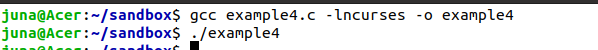

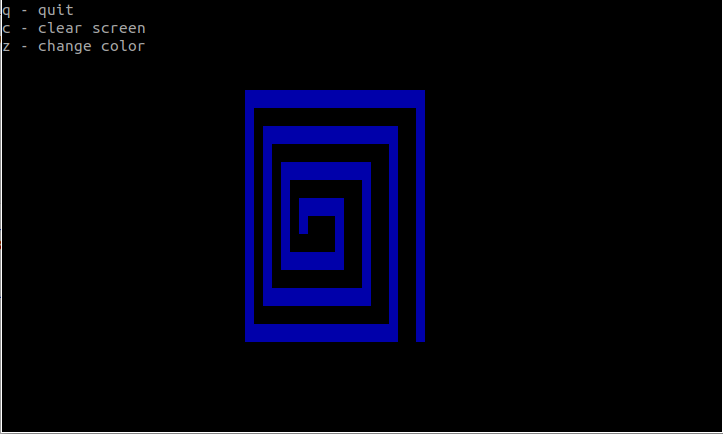

Попробуем теперь простейшее использование **ncurses** на ассемблере. Приведенная ниже программа выводит сообщение "Hello world!" в центре экрана терминала.

Вот ее Сишный вариант: 

In [ ]:
/* example5_1.c */
#include <ncurses.h>
#include <stdio.h>

int main()
{      
    initscr();                      /* Start curses mode  */
    int x, y;
    y = getmaxy(stdscr)/2;
    x = getmaxx(stdscr)/2;
    move(y,x);
    printw("Hello World!");  /* Print Hello World */
    refresh();                  /* Print it on to the real screen */
    getch();                   /* Wait for user input */
    endwin();                   /* End curses mode */

    return 0;
}

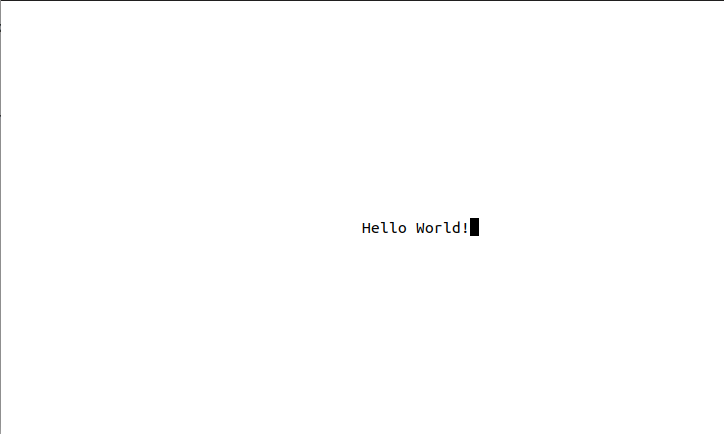

А вот аналог на ассемблере:

In [ ]:
	;; example5_2.asm
	format ELF64

	public _start
	;; Указываем необходимые внешние функции из библиотки ncurses
	extrn initscr
	extrn printw
	extrn refresh
	extrn getch
	extrn endwin
	extrn exit
	extrn stdscr
	extrn getmaxx
	extrn getmaxy
	extrn move
	

	section '.data'

	hello db "Hello World!",0

	section '.text' executable

_start:
	call initscr
	mov rdi, [stdscr] 	;загружаем экран в rdi для вызова getmaxx
	call getmaxx			
	mov r8, rax		;сохраняем максимальный размер по x в регистре r8
	call getmaxy	
	mov r9, rax 		;сохраняем максимальный размер по y в регистре r9
	xor rdx, rdx		;находим координаты середины экрана
	mov rax,r9
	mov rcx, 2
	div rcx
	mov r9, rax 		;загружаем середину по y в r9
	xor rdx, rdx
	mov rax,r8
	mov rcx, 2
	div rcx
	mov r8, rax		;загружаем середину по x в r8
	mov rdi, r9		;подготавливаем входные параметры для вызова move
	mov rsi, r8
	call move		;перемещаем курсор в середину экрана
	mov rdi, hello		;загружаем в rdi адрес сообщения
	call printw		;выводим сообщение в текущй позиции
	call refresh		;обновляем экран для визуализации изменений
	call getch			;ожидаем ввода любого символа
	call endwin		;закрываем экран, возвращаемся в обычный режим
	call exit 			;используем встроенную в ncurses функцию выхода

Создание объектного файла:

> fasm example5_2.asm

Линковка

> ld example5_2.o -lc -lncurses -dynamic-linker /lib64/ld-linux-x86-64.so.2 -o example5_2

В качестве примера рассмотрим еще более сложный пример: программа выбирает случайную позицию на экране и выводит туда случайную цифру сначала черным цветом на синем фоне, затем, когда экран в основном заполнится синими блоками, программа меняет вывод случайной цифры белым цветом на черном фоне и т.д. Программа должна систематически опрашивать клавиатуру в ожидании нажания клавиши "q", по которой завершается работа программы. 

Вначале для генерации случайных чисел и инициализации номера псевдослучайной последовательности напишем очень простую библиотеку на C.

In [ ]:
/* rnd.c */
#include<stdio.h>
#include<time.h>
void setrnd(){
  srand(time(NULL));
}

unsigned long get_random(){
  return rand();
}

Создадим из нее объектный файл:

> gcc -c rnd.c

В нашей программе для регулировки задержек по времени мы также будем использовать системную функцию **usleep(delay)**, которая задерживает выполнение на заданное количество милисекунд. Конечно, ее можно вызывать в программе на ассемблере и непосредственно, но мы предпочли создать надстройку, чтобы обе библиотеки увязыть в одну статическую библиотеку:

In [ ]:
/* delay.c */
#include <unistd.h>
void mydelay(int delay){
  usleep(delay);
}

Создаем объектный файл:

> gcc -c delay.c

Теперь все готово для того, чтобы написать основную программу на ассемблере.

In [ ]:
;;example6.asm
format ELF64

	public _start

	extrn initscr
	extrn start_color
	extrn init_pair
	extrn getmaxx
	extrn getmaxy
	extrn raw
	extrn noecho
	extrn keypad
	extrn stdscr
	extrn move
	extrn getch
	extrn clear
	extrn addch
	extrn refresh
	extrn endwin
	extrn exit
	extrn color_pair
	extrn insch
	extrn cbreak
	extrn timeout
	extrn mydelay
	extrn setrnd
	extrn get_random


	section '.bss' writable
	
	xmax dq 1
	ymax dq 1
	rand_x dq 1
	rand_y dq 1
	palette dq 1
	count dq 1

	section '.data' writable

	digit db '0123456789'

	section '.text' executable
	
_start:
	;; Инициализация
	call initscr

	;; Размеры экрана
	xor rdi, rdi
	mov rdi, [stdscr]
	call getmaxx
	mov [xmax], rax
	call getmaxy
	mov [ymax], rax

	call start_color

	;; Синий цвет
	mov rdx, 0x4
	mov rsi,0x0
	mov rdi, 0x1
	call init_pair

	;; Черный цвет
	mov rdx, 0x0
	mov rsi,0xf
	mov rdi, 0x2
	call init_pair

	call refresh
	call noecho
	call cbreak
	call setrnd

	;; Начальная инициализация палитры
	call get_digit
	or rax, 0x100
	mov [palette], rax
	mov [count], 0
        
	;; Главный цикл программы
mloop:
    ;; Выбираем случайную позицию по осям x, y
	call get_random
	xor rdx, rdx
	mov rcx, [xmax]
	div rcx
	mov [rand_x], rdx

	call get_random
	xor rdx, rdx
	mov rcx, [ymax]
	div rcx
	mov [rand_y], rdx
	
	;; Перемещаем курсор в случайную позицию
	mov rdi, [rand_y]
	mov rsi, [rand_x]
	call move

	;; Печатаем случайный символ в палитре
	mov rax, [palette]
	and rax, 0x100
	cmp rax, 0x100
	jne @f
	call get_digit
	or rax, 0x100
	mov [palette],rax
	jmp yy
	@@:
	call get_digit
	or rax, 0x200
	mov [palette],rax
	yy:
	mov  rdi,[palette]
	call addch
	;; 	call insch
	
	;; Задержка
	mov rdi,100
	call mydelay

	;; Обновляем экран и количество выведенных знакомест в заданной палитре
	call refresh
	mov r8, [count]
	inc r8
	mov [count], r8

	;; Анализируем текущее значение r8=[count]
	call analiz
    
    ;;Задаем таймаут для getch
	mov rdi, 1
	call timeout
	call getch
    
    ;;Анализируем нажатую клавишу
	cmp rax, 'q'
	je next
	jmp mloop
next:	
	call endwin
	call exit

;;Анализируем количество выведенных знакомест в заданной палитре, меняем палитру, если количество больше 10000
analiz:
	cmp r8, 10000
	jl .p
	mov r8,[palette]
	and r8, 0x100 
	cmp r8, 0x100
	je .pp
	call get_digit
	or rax, 0x100
	mov [palette], rax
	xor r8, r8
	mov [count],r8
	ret
	.pp:
	call get_digit
	or rax, 0x200
	mov [palette], rax
	xor r8, r8
	mov [count], r8
	ret
	.p:
	 ret

;;Выбираем случайную цифру
get_digit:
	push rcx
	push rdx
	call get_random
	mov rcx, 10
	xor rdx, rdx
	div rcx
	xor rax,rax
	mov al, [digit + rdx]
	pop rdx
	pop rcx
	ret

Линкуем данную библиотеку:

> fasm example6.asm

> ld example6.o rnd.o delay.o -lc -lncurses -dynamic-linker /lib64/ld-linux-x86-64.so.2 -o example6

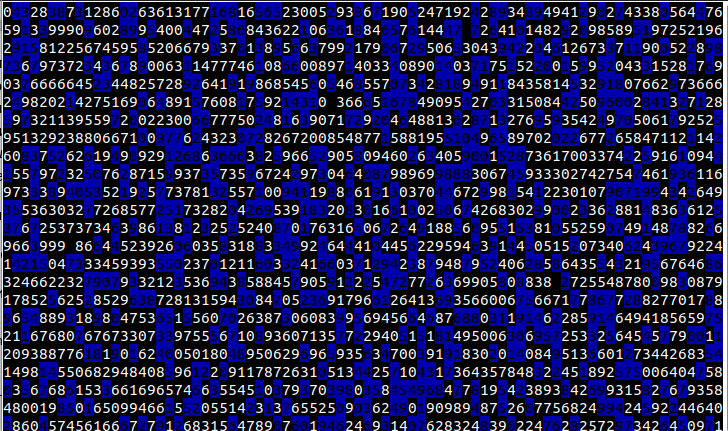

## 3. Установка и настройка Docker

Для работы в Linux с настроенным окружением удобно использовать контейнер приложений [Docker](https://ru.wikipedia.org/wiki/Docker). Это очень похоже на виртуальную машину, но по факту намного легковеснее.

Docker — это приложение, упрощающее процесс управления процессами приложения в контейнерах. Контейнеры позволяют запускать приложения в процессах с изолированными ресурсами. Они похожи на виртуальные машины, но более портативные, более эффективно расходуют ресурсы и в большей степени зависят от операционной системы хоста.

Для установки docker в окружении Ubuntu можно выполнить следующий ряд команд:
    
Обновляемся из репозиториев:
    
    > sudo apt update
    
Установливаем несколько необходимых пакетов, которые позволяют apt использовать пакеты через HTTP:
    
    > sudo apt install apt-transport-https ca-certificates curl software-properties-common
    
Добавляем ключ для официального репозитория Docker в нашу систему:
    
    > curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo apt-key add -
    
Добавляем репозиторий Docker в источники APT:

> sudo add-apt-repository "deb [arch=amd64] https://download.docker.com/linux/ubuntu focal stable"

Обновляемся:
    
> sudo apt update

Устанавливаем Docker:
    
> sudo apt install docker-ce

Docker должен быть установлен, демон-процесс запущен, а для процесса активирован запуск при загрузке. 

Можно проверить, что он запущен:

> sudo systemctl status docker

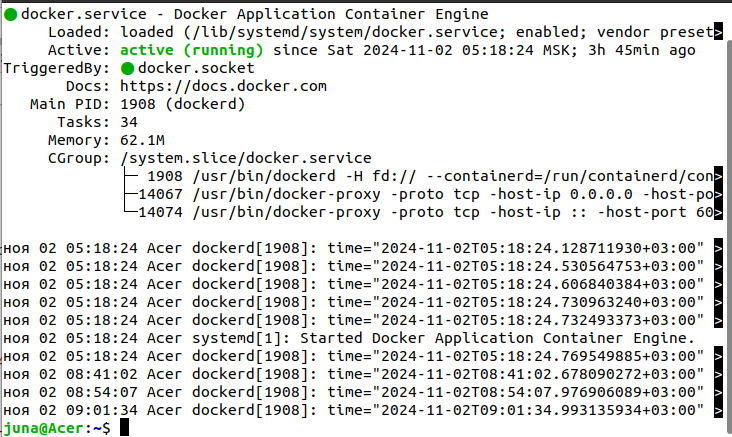

По умолчанию команда docker может быть запущена только пользователем root.

Контейнеры Docker получают из образов Docker. По умолчанию Docker загружает эти образы из Docker Hub, реестр Docker, контролируемые Docker, т.е. компанией, реализующей проект Docker. Любой может размещать свои образы Docker на Docker Hub, поэтому большинство приложений и дистрибутивов Linux, которые вам потребуется, хранят там свои образы.

Можно выполнить поиск доступных на Docker Hub образов с помощью команды search. Например, чтобы найти образ Ubuntu:

> docker search ubuntu

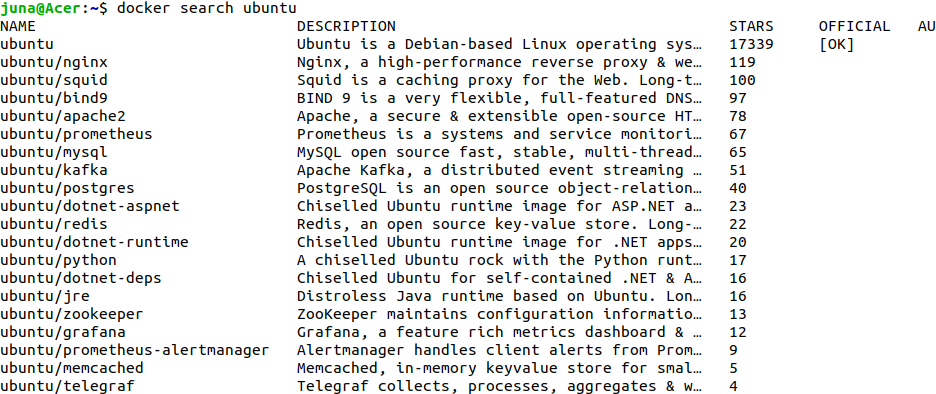

Запустите следующую команду, чтобы загрузить официальный образ ubuntu на свой компьютер:

> docker pull ubuntu

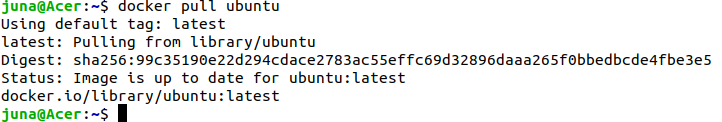

После того как образ будет загружен, вы сможете запустить контейнер с помощью загруженного образа с помощью субкоманды run. В качестве примера мы запустим контейнер с самым последним образом Ubuntu. Сочетание переключателей -i и -t предоставляет вам доступ к интерактивной командной оболочке внутри контейнера:

> docker run -it ubuntu

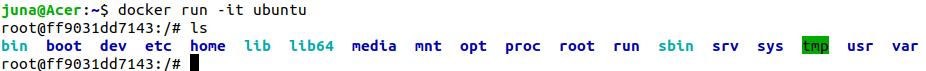

Чтобы просмотреть образы, которые были загружены на ваш компьютер, можно ввести:

> docker images

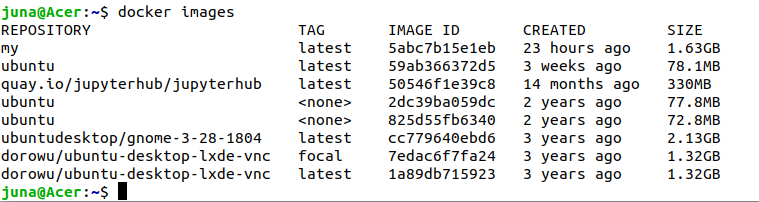

Чтобы посмотреть список запущенных и неактивных контейнеров, можно использовать команду:

> docker ps -a

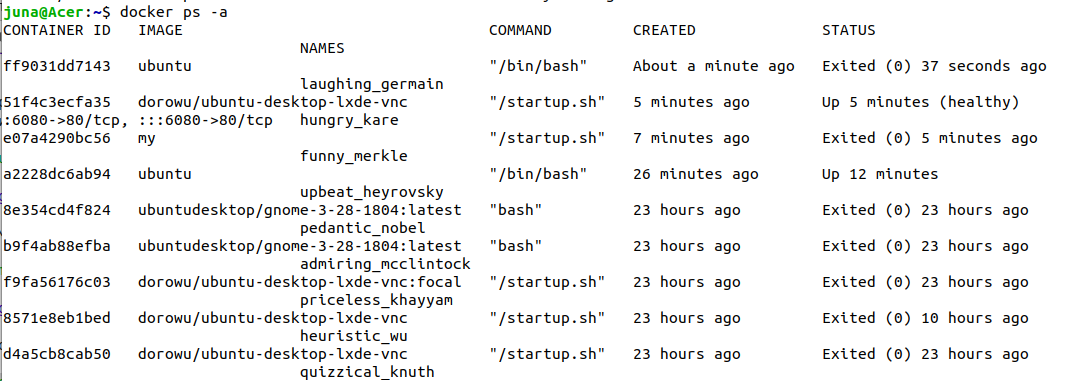

Чтобы запустить остановленный контейнер, воспользуйтесь docker start с идентификатором контейнера или именем контейнера. Давайте запустим контейнер на базе Ubuntu с идентификатором:

> docker start a2228dc6ab94

Чтобы присоединиться к уже запущенному контейнеру:

> docker attach a2228dc6ab94

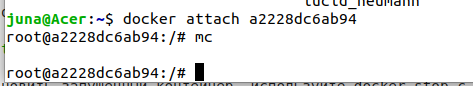

Чтобы остановить запущенный контейнер, используйте docker stop с идентификатором или именем контейнера. 

> docker stop a2228dc6ab94

После того как вы решили, что вам больше не потребуется контейнер, удалите его с помощью команды docker rm, снова добавив идентификатор контейнера или его имя.

> docker rm a2228dc6ab94

Чтобы сохранить текущие изменения в контейнере

> docker commit a2228dc6ab94  "name_commit"

После запуска контейнера Вы имеете полный доступ к Ubuntu из командной строки, реализуя стандартные способы установки программного обеспечения.

Существуют контейнеры с поддержкой GUI: например, https://hub.docker.com/r/dorowu/ubuntu-desktop-lxde-vnc/

> docker pull dorowu/ubuntu-desktop-lxde-vnc

Запускается в браузере с графическим интерфейсом lxde:

> docker run -p 6080:80 -v /dev/shm:/dev/shm dorowu/ubuntu-desktop-lxde-vnc

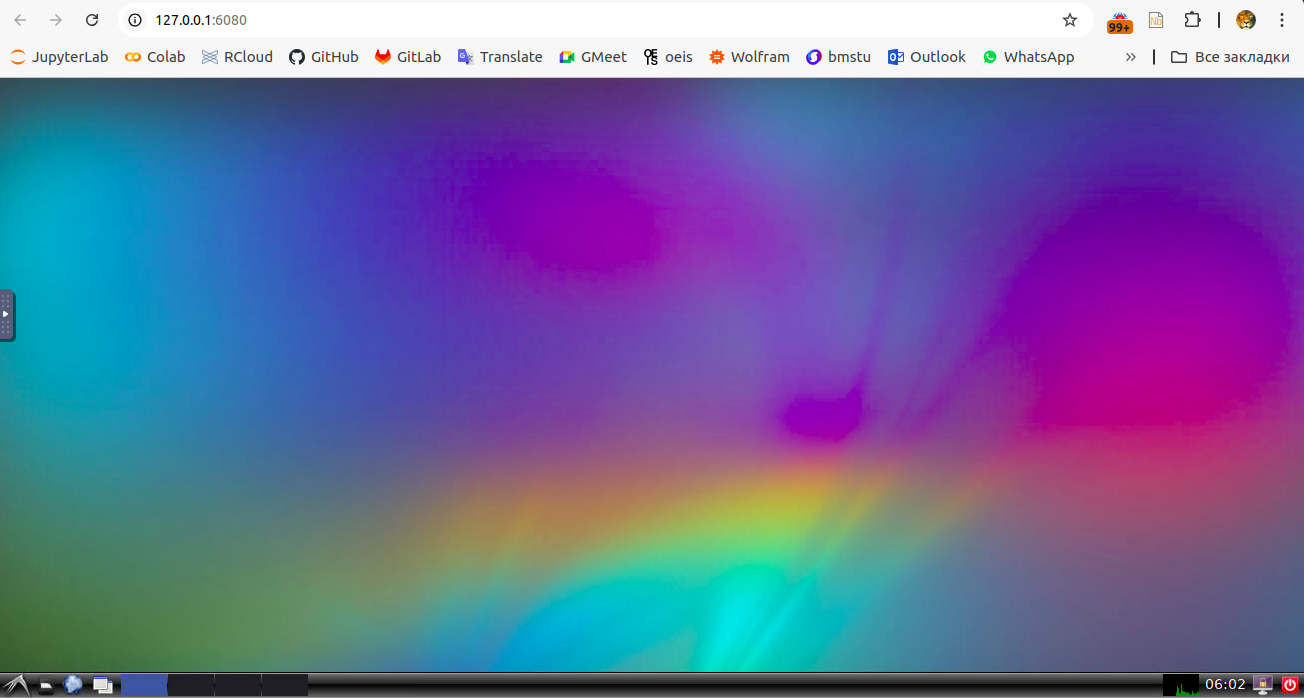